In [1]:
import hipopy.hipopy as hp
#import os
import pandas as pd
import os
import numpy as np
import numpy.ma as ma
import awkward as ak
from tqdm import tqdm
import torch
import torch_geometric as tg
import torch_geometric
from torch_geometric.data import Data
#import torch
from torch_geometric.data import InMemoryDataset, download_url
import torch_geometric.transforms as T

#NOTE: NEW 2/20/23 
from typing import List, Union

from torch_geometric.data import Data, HeteroData
from torch_geometric.data.datapipes import functional_transform
from torch_geometric.transforms import BaseTransform

import modeloss


# @functional_transform('normalize_features_new')
# class NormalizeFeaturesNew(BaseTransform):
#     r"""Column-normalizes the attributes given in :obj:`attrs` to sum-up to one
#     (functional name: :obj:`normalize_features`).

#     Args:
#         attrs (List[str]): The names of attributes to normalize.
#             (default: :obj:`["x"]`)
#     """
#     def __init__(self, attrs: List[str] = ["x"]):
#         self.attrs = attrs

#     def __call__(
#         self,
#         data: Union[Data, HeteroData],
#     ) -> Union[Data, HeteroData]:
#         for store in data.stores:
# #             print("DEBUGGING: store = ",store)
#             for key, value in store.items(*self.attrs):
# #                 print("DEBUGGING: key = ",key)
# #                 print("DEBUGGING: value.T = ",value.T)
#                 value = value.T - value.T.min()
#                 value.div_(value.sum(dim=-1, keepdim=True).clamp_(min=1.))
#                 store[key] = value.T
# #                 print("DEBUGGING: value.T = ",value.T)
#         return data

# @functional_transform('normalize_features_new_test')
# class NormalizeFeaturesNewTest(BaseTransform):
#     r"""Column-normalizes the attributes given in :obj:`attrs` to sum-up to one
#     (functional name: :obj:`normalize_features`).

#     Args:
#         attrs (List[str]): The names of attributes to normalize.
#             (default: :obj:`["x"]`)
#     """
#     def __init__(self, attrs: List[str] = ["x"]):
#         self.attrs = attrs

#     def __call__(
#         self,
#         data: Union[Data, HeteroData],
#     ) -> Union[Data, HeteroData]:
#         for store in data.stores:
# #             print("DEBUGGING: store = ",store)
#             for key, value in store.items(*self.attrs):
# #                 print("DEBUGGING: key = ",key)
# #                 print("DEBUGGING: value.T = ",value.T)
#                 value /=1000
# #                 value.div_(value.sum(dim=-1, keepdim=True).clamp_(min=1.))
#                 store[key] = value
# #                 print("DEBUGGING: value.T = ",value.T)
#         return data

In [1]:
#reading in the dataset already made. 

# my datasett
root = '/work/clas12/users/mencke/pyg_test_rec_traj_dataset_5_28_24'
#root = '/work/clas12/users/mencke/pyg_test_rec_traj_dataset_5_28_24'
from torch_geometric.data import Dataset, download_url, InMemoryDataset
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Read data into huge `Data` list.
        data_list = None

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

# Create PyG Dataset
#root = '/work/clas12/users/mfmce/pyg_test_rec_traj_dataset_5_28_24/' # 3_14_24 #OLD
root = '/work/clas12/users/mencke/pyg_test_rec_traj_dataset_5_28_24'
dataset = MyOwnDataset(
            root,
            transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
            pre_transform=None,
            pre_filter=None
        )
dataset 

MyOwnDataset(243157)

DEBUGGING: len(dataset)  =  243157
DEBUGGING: len(dataset.data)  =  5
DEBUGGING: len(dataset.y)  =  243157
DEBUGGING: dataset.y.shape =  torch.Size([243157])
torch.Size([73, 7])
tensor([[-8.4863e-03,  1.0148e-02, -3.8405e-01, -7.2666e-02,  8.4669e-02,
         -3.1220e-03, -3.8146e-01],
        [-1.2051e-02,  1.4252e-02, -3.3565e-01, -7.2893e-02,  8.4486e-02,
         -3.1226e-03, -3.3275e-01],
        [-1.9336e-02,  2.3403e-02, -2.4682e-01, -1.0361e-01,  1.4128e-01,
         -7.7334e-03, -2.4313e-01],
        [-3.3887e-02,  4.3509e-02, -1.3637e-01, -1.3592e-01,  1.8917e-01,
         -1.3754e-02, -1.2991e-01],
        [-6.6074e-02,  8.8491e-02,  9.4609e-02, -1.3574e-01,  1.8925e-01,
         -1.3749e-02,  1.0759e-01],
        [-4.7431e-02,  6.2498e-02, -3.8960e-02, -1.3574e-01,  1.8925e-01,
         -1.3749e-02, -2.9752e-02],
        [-4.8933e-02,  6.4592e-02, -2.8199e-02, -1.3574e-01,  1.8925e-01,
         -1.3749e-02, -1.8687e-02],
        [-4.5304e-02,  5.9532e-02, -5.4202e-02, -1.3

/w/hallb-scshelf2102/clas12/users/mfmce/venv_cuda/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Going through dataset
DONE


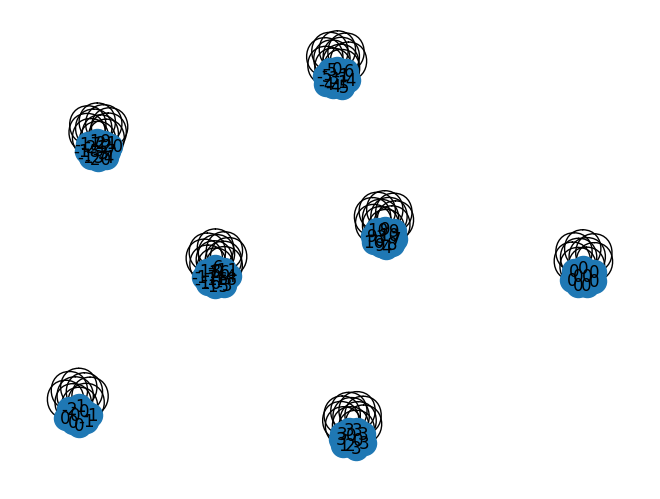

In [2]:
#do not think I need this, mainly debugging read in data set. 

#TODO: DEFINE TRANSFORMS
import torch_geometric.transforms as T
# transform=T.KNNGraph(k=2) #NOTE: GRAPH.pos needs to be defined to use this
# transform=T.NormalizeFeatures()
# transform=T.Compose([T.KNNGraph(k=3,loop=False)])
# transform = T.Compose([T.KNNGraph(k=10,loop=True),NormalizeFeaturesNewTest(),T.ToUndirected(),T.AddSelfLoops()]) #T.AddSelfLoops(),
transform=None #NOTE: FOR SOME REASON T.ToUndirected() is changing the length of the graph labels??!?!?!?!?!?!RRRRRRG FRUSTRATING.
transform=T.NormalizeFeatures()
#TODO: OPEN DATASET
# import torch
# from torch_geometric.data import InMemoryDataset, download_url

# class MyOwnDataset(InMemoryDataset):
#     def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
#         super().__init__(root, transform, pre_transform, pre_filter)
#         print("INFO: self.processed_paths = ",self.processed_paths)
#         self.data, self.slices = torch.load(self.processed_paths[0])
#         print("LOADED self.data len = ",len(self.data))#DEBUGGING
#         print("LOADED self.slices len = ",len(self.slices))#DEBUGGING

#     @property
#     def raw_file_names(self):
#         return ['some_file_1', 'some_file_2']

#     @property
#     def processed_file_names(self):
#         return ['data.pt']

#     def process(self):
#         # Read data into huge `Data` list.
#         data_list = None

#         if self.pre_filter is not None:
#             data_list = [data for data in data_list if self.pre_filter(data)]

#         if self.pre_transform is not None:
#             data_list = [self.pre_transform(data) for data in data_list]

#         data, slices = self.collate(data_list)
#         torch.save((data, slices), self.processed_paths[0])

# root = '/work/clas12/users/mfmce/pyg_test_dataset_1_4_23/'
# # root = "/work/clas12/users/mfmce/pyg_datasets_lambda_rec_traj_12_11_23/" #NOTE: DATA SHOULD BE SAVED IN <root>/processed/data.pt
# # root = "/work/clas12/users/mfmce/pyg_datasets_FROM_DGL_3_22_23/"
# # root = "/work/clas12/users/mfmce/pyg_datasets_FROM_DGL_BALANCED_3_22_23/"
# # # root = "/work/clas12/users/mfmce/pyg_datasets_TEST_PIPELINE_3_22_23/"
# dataset = MyOwnDataset(root, transform=None, pre_transform=None, pre_filter=None)

import torch
from torch_geometric.data import InMemoryDataset, download_url


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Read data into huge `Data` list.
        data_list = None

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

# Create PyG Dataset
root = '/work/clas12/users/mfmce/pyg_test_rec_traj_dataset_5_28_24/' # 3_14_24 #OLD
dataset = MyOwnDataset(
            root,
            transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
            pre_transform=None,
            pre_filter=None
        )
# DEBUGGING=True
# if DEBUGGING:
#     from torch_geometric.datasets import TUDataset
#     dataset = TUDataset(root='/home/mfmce/drop', name='MUTAG')
# print("DEBUGGING: len(dataset) = ",len(dataset))
data = dataset[0]
print('DEBUGGING: len(dataset)  = ',len(dataset))
print('DEBUGGING: len(dataset.data)  = ',len(dataset.data))
print('DEBUGGING: len(dataset.y)  = ',len(dataset.y))
print('DEBUGGING: dataset.y.shape = ',dataset.y.shape)
# print(data.x)
# print(dataset)
# if transform is not None: print(transform(dataset[0]).edge_index)
# if transform is not None: print(transform(dataset[0]).x)
print(data.x.shape)
print(data.x)
# print(data.x[0])
# print(data.x[0].sum())
print(data.y.shape)
print(data.y)
print("DEBUGGING: data.x.dtype = ",data.x.dtype)
print("DEBUGGING: data.y.dtype = ",data.y.dtype)
print("DEBUGGING: data.kinematics.dtype = ",data.kinematics.dtype)
print("DEBUGGING: data.y.shape = ",data.y.shape)
print("DEBUGGING: data.y = ",data.y)
g = tg.utils.to_networkx(data,to_undirected=True)
import networkx as nx
node_labels = {i:int(val.item()*100) for i, val in enumerate(data.x[:,0])}
nx.draw(g,labels=node_labels)
print("Going through dataset")
for idx, d in enumerate(dataset):
    if d.y.shape[0]>2:
        print("d.y = ",d.y)
        print("idx = ",idx)
    if torch.any(torch.isnan(d.x)):
        print("DEBUGGING: nan @ idx, d = ",idx,d)
    if torch.any(torch.isinf(d.x)):
        print("DEBUGGING: nan @ idx, d = ",idx,d)
        
print("DONE") 

In [3]:
# # Optionally use benchmark dataset
# from torch_geometric.datasets import TUDataset
# !ls -lrth /home/mfmce/drop/MUTAG
# dataset = TUDataset(root='/home/mfmce/drop/MUTAG', name='MUTAG')
# print(len(dataset))
# print(dataset[1].y)

DEBUGGING: dataset[0].y[0].item()== 0 =  True
torch.Size([1189011, 7])
torch.Size([25092])
torch.Size([11205129, 7])
torch.Size([218065])
DEBUGGING: b_sig.y.shape =  torch.Size([25092])
DEBUGGING; b_bg.y.shape =  torch.Size([218065])
DEBUGGING: type(arr1) =  <class 'numpy.ndarray'>
DEBUGGING: arr1.shape =  (25092, 11)
DEBUGGING: arr2.shape =  (218065, 11)
DEBUGGING: b_sig.x.dtype =  torch.float32
DEBUGGING: b_bg.x.dtype  =  torch.float32
DEBUGGING: b_sig.kinematics[0].dtype =  torch.float32


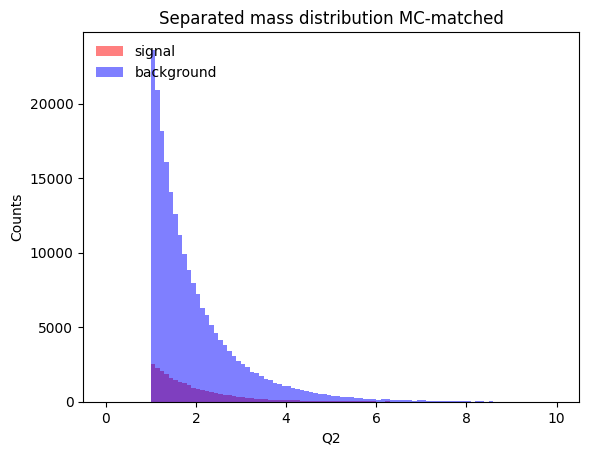

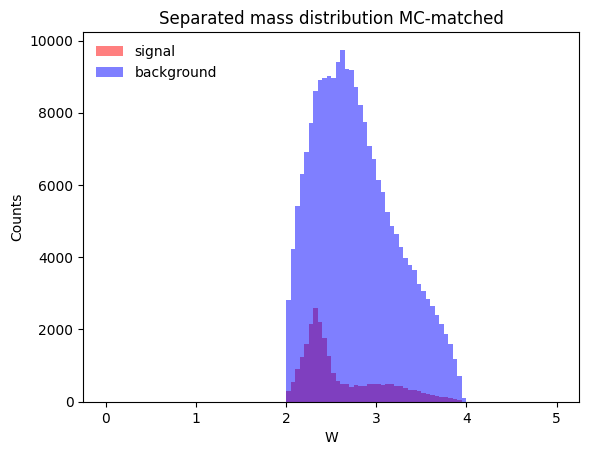

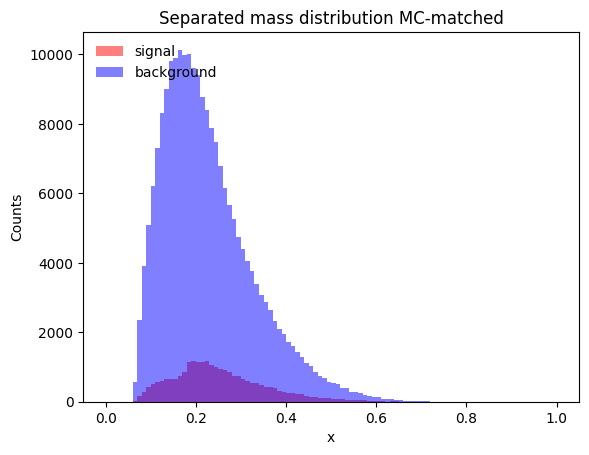

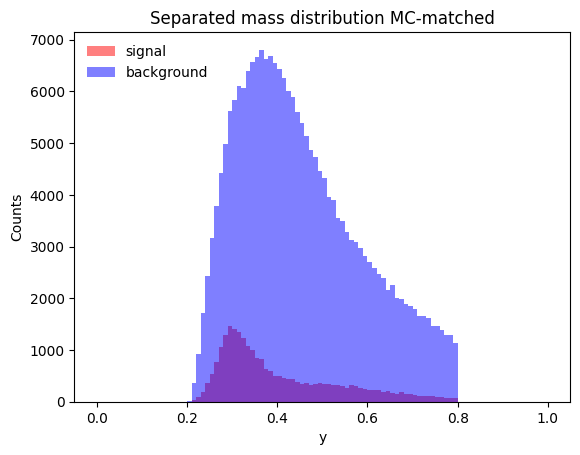

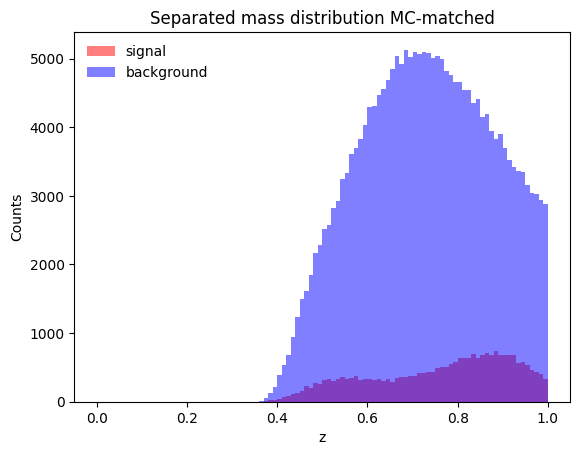

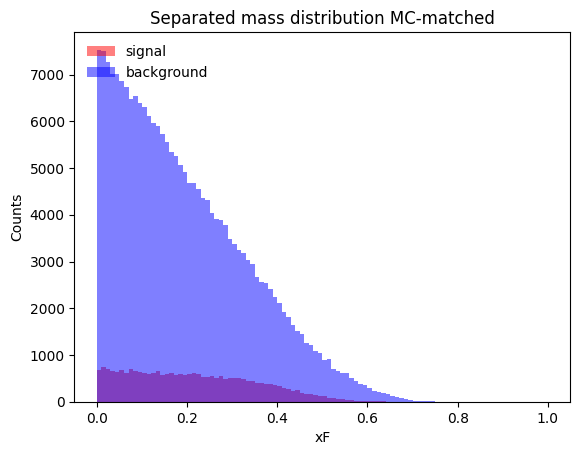

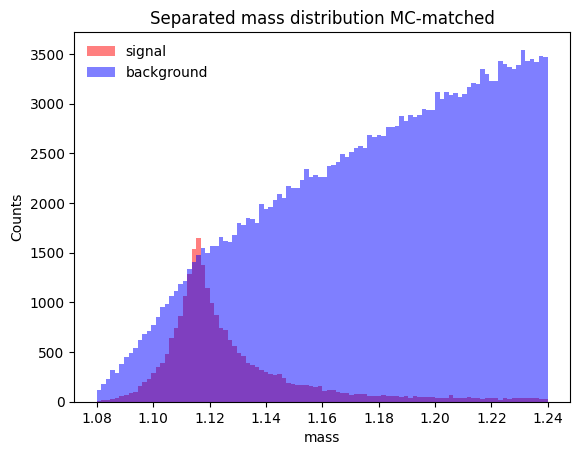

In [4]:
#first part was 1,0 vertex. I dont need that. Butit also defines signal to noise and other stuff. Then plot signal to noise for lots. Also I do not have the true values for lamba. 

l_sig = []
l_bg = []
print("DEBUGGING: dataset[0].y[0].item()== 0 = ",dataset[0].y[0].item()==0)
for data in dataset:
#     if len(data.y)!=2: print("DEBUGGING: len(data.y) = ",len(data.y))
    if data.y[0].item()==1:
        l_sig.append(data)
    else:
        l_bg.append(data)
b_sig = torch_geometric.data.Batch().from_data_list(l_sig)
b_bg = torch_geometric.data.Batch().from_data_list(l_bg)
print(b_sig.x.shape)
print(b_sig.y.shape)
print(b_bg.x.shape)
print(b_bg.y.shape)

import matplotlib.pyplot as plt

def plot_data_separated(array_sig,array_bg,title=None,xlabel='index',nbins=100,low=-1.1,high=1.1):
    
    array_sig = array_sig.flatten()
    array_bg = array_bg.flatten()

    # Plot MC-Matched distributions
    f = plt.figure()
    if title != None:
        plt.title(title)
    plt.title('Separated mass distribution MC-matched')
    plt.hist(array_sig, color='r', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='signal')
    plt.hist(array_bg, color='b', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='background')
    plt.legend(loc='upper left', frameon=False)
    plt.ylabel('Counts')
    plt.xlabel(xlabel)
#     f.savefig(xlabel+'_separated_'+todays_date+'.png')
    plt.show()
    
arr1 = b_sig.kinematics
arr2 = b_bg.kinematics

print("DEBUGGING: b_sig.y.shape = ",b_sig.y.shape)
print("DEBUGGING; b_bg.y.shape = ",b_bg.y.shape)
    
# arr1 = []
# for el in b_sig.kinematics:
#     arr1.extend(el)
# arr2 = []
# for el in b_bg.kinematics:
#     arr2.extend(el)

arr1 = np.array(arr1)
arr2 = np.array(arr2)

print("DEBUGGING: type(arr1) = ",type(arr1))
print("DEBUGGING: arr1.shape = ",arr1.shape)
print("DEBUGGING: arr2.shape = ",arr2.shape)

print("DEBUGGING: b_sig.x.dtype = ",b_sig.x.dtype)
print("DEBUGGING: b_bg.x.dtype  = ",b_bg.x.dtype)

print("DEBUGGING: b_sig.kinematics[0].dtype = ",b_sig.kinematics[0].dtype)
    
# Plot data separated distributions
plot_data_separated(arr1[:,3],arr2[:,3],xlabel="Q2",low=0.0,high=10.0)
plot_data_separated(arr1[:,5],arr2[:,5],xlabel="W",low=0.0,high=5.0)
plot_data_separated(arr1[:,6],arr2[:,6],xlabel="x",low=0.0,high=1.0)
plot_data_separated(arr1[:,7],arr2[:,7],xlabel="y",low=0.0,high=1.0)
plot_data_separated(arr1[:,8],arr2[:,8],xlabel="z",low=0.0,high=1.0)
plot_data_separated(arr1[:,9],arr2[:,9],xlabel="xF",low=0.0,high=1.0)
plot_data_separated(arr1[:,10],arr2[:,10],xlabel="mass",low=1.08,high=1.24)
# plot_data_separated(arr1[:,4],arr2[:,4],xlabel="chi2")
# plot_data_separated(arr1[:,5],arr2[:,5],xlabel="pid")
# plot_data_separated(arr1[:,6],arr2[:,6],xlabel="status")

In [5]:
#TODO: CREATE MODEL
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.norm import GraphNorm, BatchNorm

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
#         torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)#.jittable() #NOTE: NEEDED FOR DEPLOYMENT IN CMAKE
        self.conv2 = GCNConv(hidden_channels, hidden_channels)#.jittable()
        self.conv3 = GCNConv(hidden_channels, hidden_channels)#.jittable()
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
        self.bn1 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn2 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn3 = torch_geometric.nn.norm.GraphNorm(hidden_channels)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
#         print("x = ",x)
#         print("DEBUGGING: in GCN: begin: x.requires_grad = ",x.requires_grad)
        x = self.conv1(x, edge_index)
#         print("DEBUGGING: in GCN: self.conv1(x, edge_index): x.requires_grad = ",x.requires_grad)
        x = self.bn1(x)
#         print("DEBUGGING: in GCN: self.bn2(x): x.requires_grad = ",x.requires_grad)
#         print("self.conv1(x,edge_index) = ",x)
        x = x.relu()
#         x = torch.nn.function.elu(x)
#         print("DEBUGGING: in GCN: x.relu(): x.requires_grad = ",x.requires_grad)
#         print("x.relu() = ",x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
#         print("DEBUGGING: in GCN: self.bn2(x): x.requires_grad = ",x.requires_grad)
#         print("self.conv2(x,edge_index) = ",x)
        x = x.relu()
#         print("x.relu() = ",x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
#         print("self.conv3(x,edge_index) = ",x)
#         print("DEBUGGING: in GCN: self.bn3(x): x.requires_grad = ",x.requires_grad)

#         # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
#         print("self.conv2(global_mean_pool(x, batch)) = ",x)
#         print("DEBUGGING: in GCN: global_mean_pool(x): x.requires_grad = ",x.requires_grad)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
#         print("DEBUGGING: in GCN: F.dropout: x.requires_grad = ",x.requires_grad)
#         print("F.dropout(x, p=0.5, training=self.training) = ",x)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
#         print("DEBUGGING: in GCN: self.lin*(x): x.requires_grad = ",x.requires_grad)
#         print("self.lin3(x) = ",x)
#         x = torch.sigmoid(x) #NOTE: DON'T SOFTMAX IF USING BCELOSS, USE SIGMOID INSTEAD
#         print("torch.sigmoid(x) = ",x)
#         print("DEBUGGING: in GCN: torch.sigmoid(x): x.requires_grad = ",x.requires_grad)
        return x


import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, GINConv, global_add_pool, global_max_pool, global_mean_pool
from torch_geometric.nn.norm import GraphNorm
from torch.nn import BatchNorm1d

class GIN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.bns   = torch.nn.ModuleList()
        hidden_dim = 128 #hidden_dim
        num_layers = 8 # num_layers
        self.num_layers = num_layers
        
        for _ in range(self.num_layers - 1):
            mlp = MLP([in_channels if _==0 else hidden_dim, hidden_dim, hidden_dim, hidden_dim],norm='batch_norm',act='relu') #NOTE ADDED EXTRA LAYER HERE
            self.convs.append(GINConv(mlp, train_eps=False))
            self.bns.append(BatchNorm1d(hidden_dim))
#             in_channels = hidden_dim

        self.mlps = torch.nn.ModuleList()
        for _ in range(self.num_layers): #NOTE: INPUT DIM FOR MLP LAYER HAS TO MATCH INPUT DIM FOR EACH GRAPH REPRESENTATION IN EACH LAYER HERE
            self.mlps.append(MLP([in_channels if _==0 else hidden_dim, hidden_dim, hidden_dim, out_channels], norm=None, dropout=0.0, act='relu')) #NOTE ADDED EXTRA LAYER HERE AND..-> CHANGED ACTIVATION FUNCTION FROM DEFAULT RELU

    def forward(self, x, edge_index, batch): #data):
        #x, edge_index, batch = data.x, data.edge_index, data.batch
        hidden_rep = [x]
        for i in range(self.num_layers - 1):
#             print("x = ",x.max().item(),x.min().item(),x.mean().item(),x.std().item())
            x = self.convs[i](x, edge_index)
#             print("x = conv(x, edge_index) = ",x.max().item(),x.min().item(),x.mean().item(),x.std().item())
#             print("i = ",i)
            x = self.bns[i](x)
#             print("x = bn(x) = ",x.max().item(),x.min().item(),x.mean().item(),x.std().item())
#             x = x.elu() #x.tanh() #x.relu()
            x = torch.nn.functional.relu(x)
#             print("x = x.relu() = ",x.max().item(),x.min().item(),x.mean().item(),x.std().item())
            hidden_rep.append(x)
#             raise RunTimeError
        score_over_layer = 0
        for i, h in enumerate(hidden_rep):
#             pooled_h = global_add_pool(h,batch)#NOTE: ORIGINAL
#             pooled_h = global_mean_pool(h,batch)
            pooled_h = global_max_pool(h,batch)
#             print("i, pooled_h = ",i," , ",pooled_h.max().item(),pooled_h.min().item(),pooled_h.mean().item(),pooled_h.std().item())
            newval = self.mlps[i](pooled_h)
            score_over_layer += newval#self.mlps[i](pooled_h)
#             print("self.mlps[i](pooled_h) = ",newval)
#             print("softmax(...) = ",torch.nn.functional.softmax(newval,dim=-1))
#         raise TypeError
        return score_over_layer

'''
    ParticleNet Implementation
'''

class ParticleStaticEdgeConv(torch_geometric.nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(ParticleStaticEdgeConv, self).__init__(aggr='max')
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, out_channels[0], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[0]), 
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[0], out_channels[1], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[1], out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
            torch.nn.ReLU()
        )

    def forward(self, x, edge_index, k):
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, edge_index, x_i, x_j):
        tmp = torch.cat([x_i, x_j - x_i], dim = 1)

        out_mlp = self.mlp(tmp)

        return out_mlp

    def update(self, aggr_out):
        return aggr_out

class ParticleDynamicEdgeConv(ParticleStaticEdgeConv):
    def __init__(self, in_channels, out_channels, k=7):
        super(ParticleDynamicEdgeConv, self).__init__(in_channels, out_channels)
        self.k = k
        self.skip_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_channels, out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
        )
        self.act = torch.nn.ReLU()

    def forward(self, pts, fts, batch=None):
        edges = torch_geometric.nn.knn_graph(pts, self.k, batch, loop=False, flow=self.flow)
        aggrg = super(ParticleDynamicEdgeConv, self).forward(fts, edges, self.k)
        x = self.skip_mlp(fts)
        out = torch.add(aggrg, x)
        return self.act(out)


# class ParticleNet(torch.nn.Module):

#     def __init__(self, settings):
#         super().__init__()
#         previous_output_shape = settings['input_features']

#         self.input_bn = torch_geometric.nn.BatchNorm(settings['input_features'])

#         self.conv_process = torch.nn.ModuleList()
#         for layer_idx, layer_param in enumerate(settings['conv_params']):
#             K, channels = layer_param
#             self.conv_process.append(ParticleDynamicEdgeConv(previous_output_shape, channels, k=K).to(settings['device']))#NOTE: Originally : .to(DEVICE)
#             previous_output_shape = channels[-1]



#         self.fc_process = torch.nn.ModuleList()
#         for layer_idx, layer_param in enumerate(settings['fc_params']):
#             drop_rate, units = layer_param
#             seq = torch.nn.Sequential(
#                 torch.nn.Linear(previous_output_shape, units),
#                 torch.nn.Dropout(p=drop_rate),
#                 torch.nn.ReLU()
#             ).to(settings['device'])#NOTE: Originally : .to(DEVICE)
#             self.fc_process.append(seq)
#             previous_output_shape = units


#         self.output_mlp_linear = torch.nn.Linear(previous_output_shape, settings['output_classes'])
#         self.output_activation = torch.nn.Softmax(dim=1)

#     def forward(self, batch):
#         fts = self.input_bn(batch.x)
#         pts = batch.pos

#         for idx, layer in enumerate(self.conv_process):
#             fts = layer(pts, fts, batch.batch)
#             pts = fts

#         x = torch_geometric.nn.global_mean_pool(fts, batch.batch)

#         for layer in self.fc_process:
#             x = layer(x)

#         x = self.output_mlp_linear(x)
# #         x = self.output_activation(x)
#         return x

# settings = {
#     "conv_params": [
#         (2, (64, 64, 64)),
#         (2, (64, 64, 64)),
# #         (2, (64, 64, 256)),
# #         (16, (64, 64, 64)),
# #         (16, (128, 128, 128)),
# #         (16, (256, 256, 256)),
#     ],
#     "fc_params": [
#         (0.5, 64)
# #         (0.1, 256)
#     ],
#     "input_features": dataset.num_node_features, # default was 4 (e, px, py, pz)
#     "output_classes": dataset.num_classes,       # default was 2
#     "device":device
# }

# # model = ParticleNet(settings)
# # # model = model.to(DEVICE)

# # print(model) 

model = GCN(dataset.num_node_features,64,2)
# model = GIN(in_channels=dataset.num_node_features,out_channels=2)
print(model)
print("\ndataset[0].pos = ",dataset[0].pos)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=2, bias=True)
  (bn1): GraphNorm(64)
  (bn2): GraphNorm(64)
  (bn3): GraphNorm(64)
)

dataset[0].pos =  None


In [6]:
#TODO: PUT MODEL ON DEVICE
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device = ",device)
model = model.to(device)
print("DEBUGGING: torch.cuda.is_available() = ",torch.cuda.is_available()) 

Device =  cuda:0
DEBUGGING: torch.cuda.is_available() =  True


In [7]:
#TODO: SPLIT DATASET
from torch.utils.data import random_split #TODO: SEE IF YOU CAN USE THIS
# torch.manual_seed(12345)
print('DEBUGGING: BEFORE: dataset.y.shape = ',dataset.y.shape)
dataset = dataset.shuffle()
print('DEBUGGING: AFTER:  dataset.y.shape = ',dataset.y.shape)

print(len(dataset))

fracs = [0.8, 0.1, 0.1] #NOTE: SHOULD CHECK np.sum(fracs) == 1 and len(fracs)==3
fracs = [torch.sum(torch.tensor(fracs[:idx])) for idx in range(1,len(fracs)+1)]
print(fracs)
split1, split2 = [int(len(dataset)*frac) for frac in fracs[:-1]]
train_dataset = dataset[:split1]
val_dataset = dataset[split1:split2]
test_dataset = dataset[split2:] 

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

print("train_dataset")
for idx, d in enumerate(train_dataset):
    if d.y.shape[0]>2:
        print("d.y = ",d.y)
        print("idx = ",idx)
        
print("val_dataset")
for idx, d in enumerate(val_dataset):
    if d.y.shape[0]>2:
        print("d.y = ",d.y)
        print("idx = ",idx)
        
print("test_dataset")
for idx, d in enumerate(test_dataset):
    if d.y.shape[0]>2:
        print("d.y = ",d.y)
        print("idx = ",idx)

DEBUGGING: BEFORE: dataset.y.shape =  torch.Size([243157])
DEBUGGING: AFTER:  dataset.y.shape =  torch.Size([243157])
243157
[tensor(0.8000), tensor(0.9000), tensor(1.)]
Number of training graphs: 194525
Number of validation graphs: 24316
Number of test graphs: 24316
train_dataset
val_dataset
test_dataset


In [8]:
#TODO: CREATE DATALOADERS
from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler
print("DEBUGGING: train_dataset.y.shape = ",train_dataset.y.shape)
_, train_counts = np.unique(train_dataset.y, return_counts=True)
print("DEBUGGING: np.unique(train_dataset) = ",_,train_counts) 
train_weights = [1/train_counts[i] for i in train_dataset.y]
train_sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_dataset), replacement=True)
_, val_counts = np.unique(val_dataset.y, return_counts=True)
print("DEBUGGING: np.unique(val_dataset) = ",_,val_counts)
val_weights = [1/val_counts[i] for i in val_dataset.y]
val_sampler = WeightedRandomSampler(weights=val_weights, num_samples=len(val_dataset), replacement=True)
_, test_counts = np.unique(test_dataset.y, return_counts=True)
print("DEBUGGING: np.unique(test_dataset) = ",_,test_counts)
test_weights = [1/test_counts[i] for i in test_dataset.y]
test_sampler = WeightedRandomSampler(weights=test_weights, num_samples=len(test_dataset), replacement=True)

batch_size = 32
use_weighted_samplers = False
if not use_weighted_samplers:
    train_sampler, val_sampler, test_sampler = None, None, None
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, shuffle=False)#, drop_last=True)
val_loader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#NOTE: #TODO: Try no sampling here for evaluation...

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    break 

# print("train_loader")
# for idx, d in enumerate(train_loader):
#     if d.y.shape[0]!=batch_size:
#         print("d.y = ",d.y)
#         print("idx = ",idx)
        
# print("val_loader")
# for idx, d in enumerate(val_loader):
#     if d.y.shape[0]!=batch_size:
#         print("d.y = ",d.y)
#         print("idx = ",idx)
        
# print("test_loader")
# for idx, d in enumerate(test_loader):
#     if d.y.shape[0]!=batch_size:
#         print("d.y = ",d.y)
#         print("idx = ",idx)

DEBUGGING: train_dataset.y.shape =  torch.Size([194525])
DEBUGGING: np.unique(train_dataset) =  [0 1] [174384  20141]
DEBUGGING: np.unique(val_dataset) =  [0 1] [21861  2455]
DEBUGGING: np.unique(test_dataset) =  [0 1] [21820  2496]
Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[1573, 7], edge_index=[2, 16597], y=[32], kinematics=[32, 11], rec_indices=[64], batch=[1573], ptr=[33])



In [9]:
# # Instantiate model, optimizer, and loss function
# model = GCN(dataset.num_node_features,64,dataset.num_classes).to(device)
# Compile model
# model = torch_geometric.compile(model, dynamic=True)#NOTE: Not sure why this throws error now...
print("DEBUGGING: dataset.num_classes")
model = GIN(dataset.num_node_features, dataset.num_classes).to(device)
print("DEBUGGING: dataset.num_classes = ",dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print("DEBUGGING: y[0] = ",torch_geometric.data.Batch().from_data_list(train_dataset).y[0])
print("DEBUGGING: len(train_dataset) = ",len(train_dataset))
print("DEBUGGING: len(batch(t_ds)) = ",len(torch_geometric.data.Batch().from_data_list(train_dataset)))
print("DEBUGGING: y.shape = ",torch_geometric.data.Batch().from_data_list(train_dataset).y.shape)
print("DEBUGGING: y[0:10] = ",torch_geometric.data.Batch().from_data_list(train_dataset).y[0:10])
# data_labels = torch_geometric.data.Batch().from_data_list(train_dataset).y[:,0] #NOTE: THIS IS FOR 2D Labels






##########################################################################
#chnage stuff
data_labels = train_dataset.y
unique, counts = np.unique(data_labels,return_counts=True)
print("DEBUGGING: unique, counts = ",unique,counts)
weight_signal = counts[1]/counts[0]#DEBUGGING MULTIPLY BY 2 ...
print("weight_signal = ",weight_signal) 
weight = torch.FloatTensor([weight_signal, 1.0]).to(device) #NOTE: That labels are [sg?,bg?] so label 0 in this case is sg and label 1 is bg.
print("DEBUGGING: weight = ",weight)
criterion = torch.nn.CrossEntropyLoss(weight=weight if not use_weighted_samplers else None,reduction='mean')

DEBUGGING: dataset.num_classes
DEBUGGING: dataset.num_classes =  2
DEBUGGING: y[0] =  tensor(0)
DEBUGGING: len(train_dataset) =  194525
DEBUGGING: len(batch(t_ds)) =  194525
DEBUGGING: y.shape =  torch.Size([194525])
DEBUGGING: y[0:10] =  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
DEBUGGING: unique, counts =  [0 1] [174384  20141]
weight_signal =  0.11549798146618956
DEBUGGING: weight =  tensor([0.1155, 1.0000], device='cuda:0')


In [10]:
# # data_labels = torch_geometric.data.Batch().from_data_list(dataset).y
# # unique, counts = np.unique(data_labels,return_counts=True)
# weight_signal = counts[0]/counts[1]
# print(weight_signal)

In [11]:
# from modeloss.pytorch import MoDeLoss

# #NOTE: Require: bins<batch_size
# flatness_loss = MoDeLoss(bins=4,background_label=0,background_only=True,order=0,normalize=False)

# #NOTE: Module init definition below:

# # def __init__(self,bins=32,sbins=32,memory=False,background_label=0,background_only=True,power=2,order=0,lambd=None,max_slope=None,monotonic=False,eps=\
# # 1e-4,dynamicbins=True,normalize=True,sign_func="tanh"):
# """                                                                                                                                                
# Wrapper class for MoDe  Loss. Creates a callable that calculates the MoDe loss between two tensors.                                                

# Parameters                                                                                                                                         
# ----------                                                                                                                                         
# bins : int                                                                                                                                         
#     Number of bins in the biased feature to integrate over.                                                                                        
# sbins : int                                                                                                                                        
#     Number of bins of scores values. A large number of bins gives a more accurate loss but does not affect the gradients.                          
# memory : bool, default True                                                                                                                        
#     If True, integrate over biased feature locally i.e. on a per batch basis. Otherwise save data (biased feature and scores) from previous batche\
# s and perform a global MoDe claculation.                                                                                                                   
# background_only : bool, default True                                                                                                               
#     If True, only apply the loss to the response of background events (label 1.) Otherwise, constrain the response for the whole tensor not just t\
# he subset labaled 1 (i.e. both classes at the same time if two classes are provided.)                                                                      
# power : int, default 2                                                                                                                             
#     Power used to calculate the flat part of the loss. E.g. L2: LegendreLoss=mean((F(s)-F_flat(s))**2)                                             
# order : int={0,1,2}, default 0                                                                                                                     
#     Order up tp which the Legendre expansion is computed.                                                                                          
# lambd : float, optional 8                                                                                                                            
#     Amount of penalization to high slopes.                                                                                                         
# max_slope : float, optional                                                                                                                        
# Specify a maximum slope in the decomposition as a fraction of the minimal slope that corresponds to 0 efficiency near some edge. If max_slope<1 th\
# en the response will have nonzero efficiency everywhere, otherwise the slope can ve large enough that efficiency is 0 near one edge. If None, the slope is\
# unconstrained.                                                                                                                                            
# monotonic : bool, default True                                                                                                                     
#     If True, forces the response to be monotonic for quadratic fits.                                                                               
# eps : float, default 1e-4                                                                                                                          
#     Small number used to prevent divergences in fractions used if monotonic is True.                                                               
# dynamicbins : bool, default True                                                                                                                   
#     If True, the bins of unbiased feature are adaptive i.e. have equal occupancy. Otherwise the bin width is fixed. If the bin width is fixed, the\
# bins are padded up to the bin with highest occupancy which might use more memory.                                                                         
# normalize : bool, default True                                                                                                                     
#     If True, the values of the biased feature are normalzied between -1 and 1 on a per batch basis.    
# """
# # masses = data.kinematics[:,0,0] 
# # my_mean = 1.08
# # my_sig = (1.24-1.08)/2
# # masses -= (my_mean+my_sig)
# # masses /= my_sig
# # mloss_coeff = 1.0
# # print("DEBUGGING: masses.shape = ",masses.shape)
# # loss = mloss_coeff * flatness_loss(out,data.y,masses)+criterion(out,data.y) 

'                                                                                                                                                \nWrapper class for MoDe  Loss. Creates a callable that calculates the MoDe loss between two tensors.                                                \n\nParameters                                                                                                                                         \n----------                                                                                                                                         \nbins : int                                                                                                                                         \n    Number of bins in the biased feature to integrate over.                                                                                        \nsbins : int                                                                                               

In [18]:
# Define training and testing routines 
def train(): 
    model.train()

    for idx, data in tqdm(enumerate(train_loader)):  # Iterate in batches over the training dataset.
        data = data.to(device)
        optimizer.zero_grad()  # Clear gradients.
#         x = data.x
#         y = data.y
#         if batch_size!=y.shape[0]:
#             print("DEBUGGING: x.shape = ",x.shape)
#             print("DEBUGGING: len(x) = ",len(x))
#             print("DEBUGGING: y.shape = ",y.shape)
#             print("DEBUGGING: len(y) = ",len(y)) 
# #             print("DEBUGGING: x = ",x)
#             print("DEBUGGING: y = ",y)
#             print("DEBUGGING: idx = ",idx)
# #             print("DEBUGGING: edge_index = ",data.edge_index)
# #         edge_index = data.edge_index
# #         batch = data.batch
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass. 
#         out = torch.nn.functional.softmax(out,dim=-1)
#         print("DEBUGGING: out.dtype = ",out.dtype)
#         print("DEBUGGING: data.y.dtype = ",data.y.dtype)
#         print("DEBUGGING: out.shape = ",out.shape)
#         print("DEBUGGING: data.y.shape = ",data.y.shape)
#         print("DEBUGGING: out = ",out)
#         print("DEBUGGING: y   = ",data.y)
#         print("DEBUGGING: y.shape   = ",data.y.shape)
#         break
#         print("DEBUGGING: out.device = ",out.device)
#         print("DEBUGGING: data.y.device = ",data.y.device)
#         print("DEBUGGING: device = ",device)
#         print("DEBUGGING: out.shape = ",out.shape)
#         print("DEBUGGING: data.y.shape = ",data.y.shape)
#         print("DEBUGGING: out.dtype = ",out.dtype)
#         print("DEBUGGING: data.y.dtype = ",data.y.dtype)
#         print("DEBUGGING: data.kinematics = ",data.kinematics)
        if idx<5: print("DEBUGGING: data.kinematics.shape = ",data.kinematics.shape)
#         print("DEBUGGING: tg.utils.unbatch(data.src,data.)")
        masses = data.kinematics[:,10]
        my_mean = 1.08
        my_sig = (1.24-1.08)/2
        masses -= (my_mean+my_sig)
        masses /= my_sig
        mloss_coeff = 1.0
        if idx<5: print("DEBUGGING: masses.shape = ",masses.shape)
#         loss = mloss_coeff * flatness_loss(out,data.y,masses)+criterion(out,data.y)
        loss = criterion(out, data.y)  # Compute the loss.
#         break#DEBUGGING!
#         out = torch.nn.functional.softmax(out,dim=-1)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
#         optimizer.zero_grad()  # Clear gradients.
        
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
@torch.no_grad()
def test(loader):
    model.eval()
#     for name, param in model.named_parameters():
#         if 'weight' in name:
#             print("DEBUGGING: name, param = ",name,param)
    correct = 0
    loss_ = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    decisions = []
    outputs = [] 
    y_true = []
    for data in tqdm(loader):  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
#         out = torch.nn.functional.softmax(out,dim=-1)
        loss = criterion(out, data.y)
        loss_ += loss.item()
        out = torch.nn.functional.softmax(out,dim=-1)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
#         print("DEBUGGING: np.unique(pred, return_counts=True) = ",np.unique(pred.cpu(),return_counts=True))
#         print("DEBUGGING: pred.shape = ",pred.shape)
#         print("DEBUGGING: data.y.shape = ",data.y.shape)
        correct += int((pred == data.y).sum())  # Check against ground-truth labels. #NOTE: THAT NEED index :,1 since labels are 0,1 (pred==1) if bg and 1,0 (pred==0) if true
#         tp += int(torch.logical_and(pred==data.y,pred==1).sum())#NOTE: THIS ONLY WORKS FOR BINARY CLASSIFICATION
#         fp += int(torch.logical_and(pred!=data.y,pred==1).sum())
#         fn += int(torch.logical_and(pred!=data.y,pred==0).sum())
#         tn += int(torch.logical_and(pred==data.y,pred==0).sum())
        cm = confusion_matrix(data.y.cpu(),pred.cpu(),labels=[0,1]) #NOTE: SAME INDEXING DOWN HEREE AS WHEN ASSIGNING CORRECT ABOVE.
        tp += cm[1,1]
        fp += cm[0,1] # bg classified as sig is 0,1
        fn += cm[1,0] # signal classified as bg is 1,0
        tn += cm[0,0]
        
        outputs.extend(out.cpu())
        decisions.extend(pred.cpu())
        y_true.extend(data.y.cpu())
        
    precision = tp / (tp + fp) # accuracy of the identified signal events
    recall = tp / (tp + fn) # efficiency
    precision_n = tn / (tn + fn)
    recall_n = tn / (tn + fp)
    
    roc_auc = roc_auc_score(y_true,decisions)
#     print("tp = ",tp)
#     print("fp = ",fp)
#     print("fn = ",fn)
#     print("tn = ",tn)
#     print("len(loader.dataset) = ",len(loader.dataset))
#     print("acc = ",correct/len(loader.dataset))
#     print("(tp+tn)/(tp+fp+tn+fn) = ",(tp+tn)/(tp+fp+tn+fn))
    return correct / len(loader.dataset), loss_ / len(loader.dataset), precision, recall, precision_n, recall_n, outputs, decisions, y_true, roc_auc # Derive ratio of correct predictions.

# acc, loss = test(train_loader)
# print(acc,loss)
# acc, loss = test(val_loader)
# print(acc, loss)

In [19]:
criterion
optimizer.param_groups[0]['lr']

0.0001

BEFORE TRAIN()


4it [00:00, 35.45it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:57, 51.77it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:46<00:00, 131.59it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:102: RuntimeWarning: invalid value encountered in scalar divide
  precision_n = tn / (tn + fn)


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:05<00:00, 130.53it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:102: RuntimeWarning: invalid value encountered in scalar divide
  precision_n = tn / (tn + fn)


Epoch  0  Train acc:  0.10353939082380156  loss:  1268.746456864076  precision:  0.10353939082380156  recall:  1.0
Epoch  0  Val   acc:  0.10096232933048199  loss:  1120.1196113155947  precision:  0.10096232933048199  recall:  1.0
BEFORE TRAIN()


5it [00:00, 44.83it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:54, 53.09it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:47<00:00, 126.77it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:06<00:00, 126.38it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events


Epoch  1  Train acc:  0.8964606091761984  loss:  1029.4265894988594  precision:  nan  recall:  0.0
Epoch  1  Val   acc:  0.899037670669518  loss:  1022.2915252118269  precision:  nan  recall:  0.0
BEFORE TRAIN()


3it [00:00, 23.37it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [02:04, 48.86it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:48<00:00, 126.25it/s]


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:06<00:00, 124.18it/s]


Epoch  2  Train acc:  0.16430278884462152  loss:  369.83184609721394  precision:  0.1080237569699405  recall:  0.9743806166525992
Epoch  2  Val   acc:  0.16285573285079782  loss:  372.8785759834381  precision:  0.10520047637951568  recall:  0.9714867617107943
BEFORE TRAIN()


5it [00:00, 44.06it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:46, 56.93it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:45<00:00, 132.32it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:05<00:00, 131.07it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events


Epoch  3  Train acc:  0.8964606091761984  loss:  480.0162463866811  precision:  nan  recall:  0.0
Epoch  3  Val   acc:  0.899037670669518  loss:  475.1386014646871  precision:  nan  recall:  0.0
BEFORE TRAIN()


4it [00:00, 36.89it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:50, 54.90it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:46<00:00, 131.94it/s]


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:05<00:00, 130.77it/s]


Epoch  4  Train acc:  0.4089397249710834  loss:  222.80761925207437  precision:  0.1313852157621835  recall:  0.839134104562832
Epoch  4  Val   acc:  0.4131847343313045  loss:  221.19191904973192  precision:  0.13113525665043088  recall:  0.8553971486761711
BEFORE TRAIN()


5it [00:00, 42.74it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:49, 55.57it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:45<00:00, 132.38it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:05<00:00, 132.40it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events


Epoch  5  Train acc:  0.8964606091761984  loss:  633.9264093575296  precision:  nan  recall:  0.0
Epoch  5  Val   acc:  0.899037670669518  loss:  647.6119097712636  precision:  nan  recall:  0.0
BEFORE TRAIN()


4it [00:00, 37.11it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:51, 54.41it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:47<00:00, 128.03it/s]


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:05<00:00, 129.64it/s]


Epoch  6  Train acc:  0.19059760956175298  loss:  274.1182774622277  precision:  0.11202346372503588  recall:  0.9842113102626483
Epoch  6  Val   acc:  0.1875308438887975  loss:  276.6375685433138  precision:  0.10869860225268015  recall:  0.9788187372708758
BEFORE TRAIN()


4it [00:00, 38.84it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:46, 56.95it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:47<00:00, 128.83it/s]


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:05<00:00, 130.33it/s]


Epoch  7  Train acc:  0.21646060917619844  loss:  308.32536557399436  precision:  0.1145842438652005  recall:  0.976267315426245
Epoch  7  Val   acc:  0.21179470307616385  loss:  313.87621601429163  precision:  0.11120934344609372  recall:  0.9735234215885947
BEFORE TRAIN()


4it [00:00, 36.79it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:57, 51.69it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:48<00:00, 126.18it/s]


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:05<00:00, 126.86it/s]


Epoch  8  Train acc:  0.23405731911065417  loss:  261.5467907364996  precision:  0.11638721509038512  recall:  0.9705079191698526
Epoch  8  Val   acc:  0.23322092449416024  loss:  263.40736537003994  precision:  0.1140459616668256  recall:  0.9743380855397149
BEFORE TRAIN()


4it [00:00, 38.99it/s]

DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])
DEBUGGING: data.kinematics.shape =  torch.Size([32, 11])
DEBUGGING: masses.shape =  torch.Size([32])


6079it [01:46, 56.86it/s]


BEFORE TEST(TRAIN_LOADER)


100%|██████████| 6079/6079 [00:46<00:00, 131.59it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events


BEFORE TEST(VAL_LOADER)


100%|██████████| 760/760 [00:05<00:00, 131.39it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events


Epoch  9  Train acc:  0.8964606091761984  loss:  301.14750166734774  precision:  nan  recall:  0.0
Epoch  9  Val   acc:  0.899037670669518  loss:  306.6040851525873  precision:  nan  recall:  0.0
ymax =  0.01


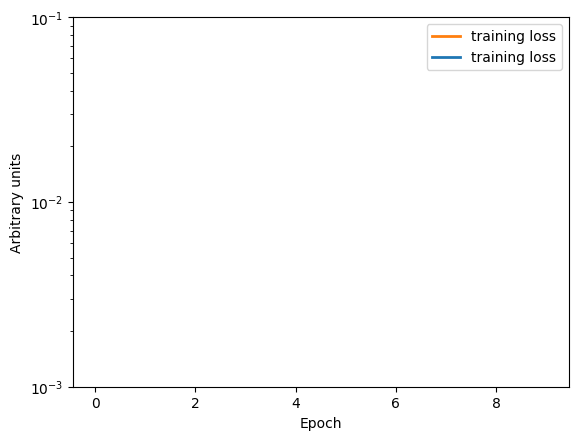

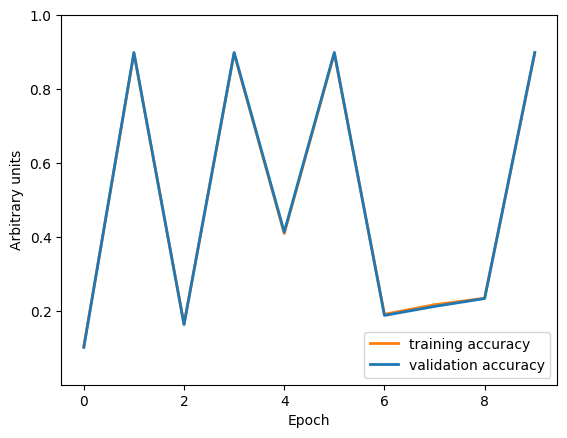

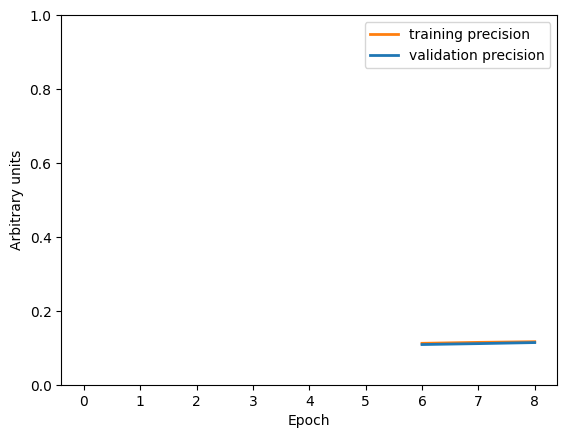

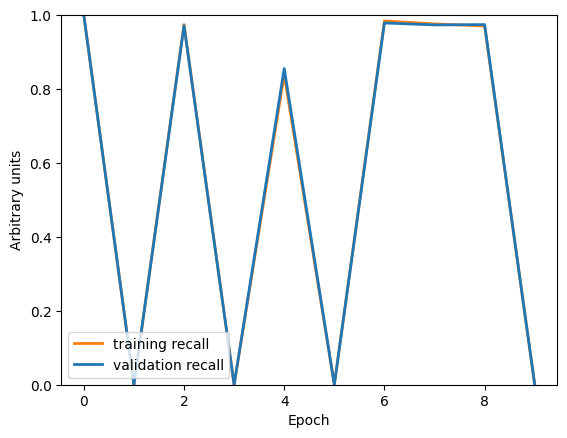

In [20]:
# Train model batch size 64 lr 0.001 epochs 30
nepochs = 10
train_metrics = {"acc":[], "loss":[], "precision":[], "recall":[], "roc_auc":[]}
val_metrics = {"acc":[], "loss":[], "precision":[], "recall":[], "roc_auc":[]}
# for name, param in model.named_parameters():
#     if 'weight' in name:
#         print("DEBUGGING: name, param = ",name,param) 
#     break
model_best_auc = None
roc_aucs = []
for epoch in range(nepochs):
    print("BEFORE TRAIN()")
    train()
    print("BEFORE TEST(TRAIN_LOADER)")
    train_acc, train_loss, train_precision, train_recall, train_precision_n, train_recall_n, _, _, __, train_roc_auc = test(train_loader)
    train_metrics["acc"].append(train_acc)
    train_metrics["loss"].append(train_loss)
    train_metrics["precision"].append(train_precision)
    train_metrics["recall"].append(train_recall)
    train_metrics["roc_auc"].append(train_roc_auc)
    print("BEFORE TEST(VAL_LOADER)")
    val_acc, val_loss, val_precision, val_recall, val_precision_n, val_recall_n, _, _, __, val_roc_auc = test(val_loader)
    if epoch==0 or val_roc_auc >np.max(val_metrics["roc_auc"]):
        model_best_auc = model
        PATH = '/work/clas12/users/mfmce/CLAS12_Lambda_resolution_REU_2023/model_best_auc.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
 #             'loss': loss,
            }, PATH)
    val_metrics["acc"].append(val_acc)
    val_metrics["loss"].append(val_loss)
    val_metrics["precision"].append(val_precision)
    val_metrics["recall"].append(val_recall)
    val_metrics["roc_auc"].append(val_roc_auc)
    print("Epoch ",epoch," Train acc: ",train_acc," loss: ",train_loss," precision: ",train_precision," recall: ",train_recall)#," precision_n: ",train_precision_n," recall_n: ",train_recall_n)
    print("Epoch ",epoch," Val   acc: ",val_acc,  " loss: ",val_loss," precision: ",val_precision," recall: ",val_recall)#," precision_n: ",val_precision_n," recall_n: ",val_recall_n)
# for name, param in model.named_parameters():
#     if 'weight' in name:
#         print("DEBUGGING: name, param = ",name,param)
#     break
import matplotlib.pyplot as plt
epochs = [i for i in range(len(train_metrics["loss"]))]
f = plt.figure() 
ymax = max(max(train_metrics['loss']),max(val_metrics['loss']))
ymax = 0.01 #max(max(train_metrics['loss']),max(val_metrics['loss']))
print("ymax = ",ymax)
plt.ylim((10**-3,10**-1))
plt.semilogy(epochs, train_metrics['loss'], color='tab:orange', linewidth=2, markersize=1, label="training loss")
plt.semilogy(epochs, val_metrics['loss'], color='tab:blue', linewidth=2, markersize=1, label="training loss")
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Arbitrary units')
plt.show()

f = plt.figure()
plt.ylim(1e-5,1)
plt.plot(epochs, train_metrics['acc'], color='tab:orange', linewidth=2, markersize=1, label="training accuracy")
plt.plot(epochs, val_metrics['acc'], color='tab:blue', linewidth=2, markersize=1, label="validation accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Arbitrary units')
plt.show()

f = plt.figure()
plt.ylim(0,1)
plt.plot(epochs, train_metrics['precision'], color='tab:orange', linewidth=2, markersize=1, label="training precision")
plt.plot(epochs, val_metrics['precision'], color='tab:blue', linewidth=2, markersize=1, label="validation precision")
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Arbitrary units') 
plt.show()


f = plt.figure()
plt.ylim(0,1)
plt.plot(epochs, train_metrics['recall'], color='tab:orange', linewidth=2, markersize=1, label="training recall")
plt.plot(epochs, val_metrics['recall'], color='tab:blue', linewidth=2, markersize=1, label="validation recall")
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Arbitrary units')
plt.show()
#NOTE: ALSO TRY CATBOOST WITH NEW VERTEXING
#NOTE: ALSO TRY GIN/PNet WITH NEW VERTEXING
#NOTE: SEE BELOW FIRST: CAN ALSO IMPLEMENT IN PL SO YOU CAN USE MULTIPLE GPUs
#NOTE: THIS WILL TAKE ROUGHLY 21min for 497000 training samples without GPU so just install GPU version of pytorch and save time.

100%|██████████| 760/760 [00:05<00:00, 129.21it/s]
/scratch/slurm/21730640/ipykernel_21625/396931283.py:100: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp) # accuracy of the identified signal events
/w/hallb-scshelf2102/clas12/users/mfmce/venv_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision2 =  0.0
precision =  0
recall2 =  0.0
recall =  0.0
precision_n =  0.8973515380819214
recall_n =  1.0
DEBUGGING: roc_auc_test =  0.5
DEBUGGING: len(outputs)    =  24316
DEBUGGING: outputs[0:10]   =  [tensor([1., 0.]), tensor([1., 0.]), tensor([1., 0.]), tensor([1., 0.]), tensor([1., 0.]), tensor([1., 0.]), tensor([1., 0.]), tensor([1., 0.]), tensor([1., 0.]), tensor([1., 0.])]
DEBUGGING: decisions[0:10] =  [tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0)]
DEBUGGING: y_true[0:10]    =  [tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0)]
DEBUGGING: AFTER CREATING np.arrays
DEBUGGING: outputs[0:10]   =  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
DEBUGGING: decisions[0:10] =  [0 0 0 0 0 0 0 0 0 0]
DEBUGGING: y_true[0:10]    =  [0 0 0 0 0 0 0 0 0 0]
DEBUGGING: type(outputs)       =  <class 'numpy.ndarray'>
DEBUGGING

IndexError: list index out of range

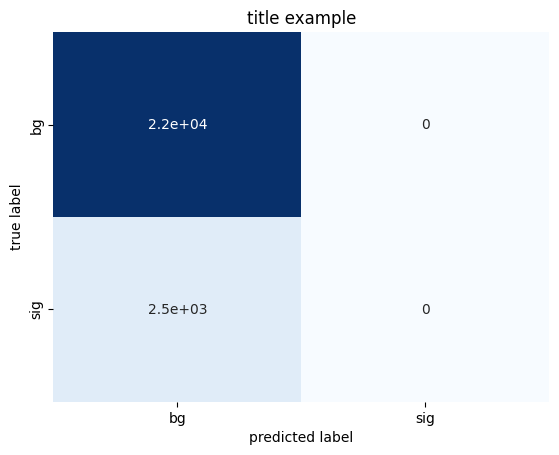

In [21]:
train_acc, train_loss, train_precision, train_recall, train_precision_n, train_recall_n, outputs, decisions, y_true, roc_auc_test = test(test_loader)
import sklearn
import seaborn as sns
cm = confusion_matrix(y_true,decisions,labels=[0,1])

#TODO: PLOT ROC CURVE
"""
TODO: Add modeloss to see if that gets rid of BG sculpting.
TODO: Implement C++/Java loading -> Make available as library function to call in your C++/Java analysis

"""

tp = cm[1,1] 
fp = cm[0,1] # bg classified as signal is 0,1
fn = cm[1,0] # signal classified as bg  is 1,0
tn = cm[0,0]
        
precision = tp / (tp + fp) if tp+fp>0 else 0
recall = tp / (tp + fn) if tp+fn>0 else 0
precision_n = tn / (tn + fn) if tn+fn>0 else 0
recall_n = tn / (tn + fp) if tn+fp>0 else 0
precision2 = sklearn.metrics.precision_score(y_true, decisions)
recall2 = sklearn.metrics.recall_score(y_true,decisions)
print("precision2 = ",precision2)
print("precision = ",precision)
print("recall2 = ",recall2)
print("recall = ",recall)
print("precision_n = ",precision_n)
print("recall_n = ",recall_n)
print("DEBUGGING: roc_auc_test = ",roc_auc_test)

def plot_matrix(cm, classes, title):
    ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False)
    ax.set(title=title, xlabel="predicted label", ylabel="true label")
    
classes = ['bg', 'sig']
title = "title example"

plot_matrix(cm, classes, title)

# Get separated network output arrays
print("DEBUGGING: len(outputs)    = ",len(outputs))
print("DEBUGGING: outputs[0:10]   = ",outputs[0:10])
print("DEBUGGING: decisions[0:10] = ",decisions[0:10])
print("DEBUGGING: y_true[0:10]    = ",y_true[0:10])
outputs   = np.array([el.tolist() for el in outputs])
decisions = np.array([el.item() for el in decisions])
y_true    = np.array([el.item() for el in y_true])
print("DEBUGGING: AFTER CREATING np.arrays")
print("DEBUGGING: outputs[0:10]   = ",outputs[0:10])
print("DEBUGGING: decisions[0:10] = ",decisions[0:10])
print("DEBUGGING: y_true[0:10]    = ",y_true[0:10])
print("DEBUGGING: type(outputs)       = ",type(outputs))
print("DEBUGGING: type(decisions)     = ",type(decisions))
print("DEBUGGING: type(y_true)        = ",type(y_true))
print("DEBUGGING: np.shape(outputs)   = ",np.shape(outputs))
print("DEBUGGING: np.shape(decisions) = ",np.shape(decisions))
print("DEBUGGING: np.shape(y_true)    = ",np.shape(y_true))
print("DEBUGGING: np.shape(decisions==1) = ",np.shape(decisions==1))
outputs_sig_true  = outputs[:,1][np.logical_and(decisions==1,y_true==1)]
outputs_sig_false = outputs[:,1][np.logical_and(decisions==1,y_true==0)]
outputs_bg_false  = outputs[:,1][np.logical_and(decisions==0,y_true==1)]
outputs_bg_true   = outputs[:,1][np.logical_and(decisions==0,y_true==0)]

l_sig_true = []
l_sig_false = []
l_bg_false = []
l_bg_true = []
k_sig_true = []
k_sig_false = []
k_bg_false = []
k_bg_true = []
for i, data in enumerate(test_dataset):
    decision = decisions[i]
    y = y_true[i]
    kin = data.kinematics.tolist()
#     if len(kin)!=13: raise TypeError
    if decision==1 and decision==y:
        l_sig_true.append(data)
        k_sig_true.append(kin[0])#NOTE: Should add matching indices specification to data objects...
    elif decision==1 and decision!=y:
        l_sig_false.append(data)
        k_sig_false.append(kin[0])
    elif decision==0 and decision!=y:
        l_bg_false.append(data)
        k_bg_false.append(kin[0])
    elif decision==0 and decision==y:
        l_bg_true.append(data)
        k_bg_true.append(kin[0])
b_sig_true = torch_geometric.data.Batch().from_data_list(l_sig_true)
b_sig_false = torch_geometric.data.Batch().from_data_list(l_sig_false)
b_bg_false = torch_geometric.data.Batch().from_data_list(l_bg_false)
b_bg_true = torch_geometric.data.Batch().from_data_list(l_bg_true)
print(b_sig.x.shape)
print(b_sig.y.shape)
print(b_bg.x.shape)
print(b_bg.y.shape)

import matplotlib.pyplot as plt

def plot_data_separated(array_sig_true,array_sig_false,array_bg_false,array_bg_true,title=None,xlabel='index',nbins=50,low=-1.1,high=1.1,logy=False):
    
    array_sig_true = array_sig_true.flatten()
    array_sig_false = array_sig_false.flatten()
    array_bg_false = array_bg_false.flatten()
    array_bg_true = array_bg_true.flatten()
    
    # Plot SIG ONLY distributions
    f = plt.figure()
    if title != None:
        plt.title(title)
    plt.title('Separated distribution MC-matched')
    plt.hist(array_sig_true, color='tab:red', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='sig true')
    plt.hist(array_sig_false, color='tab:orange', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='sig false')
#     plt.hist(array_bg_false, color='tab:green', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='bg false')
#     plt.hist(array_bg_true, color='tab:blue', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='bg true')
    plt.legend(loc='upper left', frameon=False)
    plt.ylabel('Counts')
    plt.xlabel(xlabel)
    if logy: plt.yscale('log')
#     f.savefig(xlabel+'_separated_'+todays_date+'.pdf')

    # Plot SIG AND BG distributions
    f = plt.figure()
    if title != None:
        plt.title(title)
    plt.title('Separated distribution MC-matched')
    plt.hist(array_sig_true, color='tab:red', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='sig true')
    plt.hist(array_sig_false, color='tab:orange', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='sig false')
    plt.hist(array_bg_false, color='tab:green', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='bg false')
    plt.hist(array_bg_true, color='tab:blue', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='bg true')
    plt.legend(loc='upper left', frameon=False)
    plt.ylabel('Counts')
    plt.xlabel(xlabel)
    if logy: plt.yscale('log')
#     f.savefig(xlabel+'_separated_'+todays_date+'.pdf')
    plt.show()
    
arr1 = b_sig_true.x
arr2 = b_sig_false.x
arr3 = b_bg_false.x
arr4 = b_bg_true.x
    
# # Plot data separated distributions
# plot_data_separated(arr1[:,0],arr2[:,0],arr3[:,0],arr4[:,0],xlabel="pT")
# plot_data_separated(arr1[:,1],arr2[:,1],arr3[:,1],arr4[:,1],xlabel="phi")
# plot_data_separated(arr1[:,2],arr2[:,2],arr3[:,2],arr4[:,2],xlabel="theta")
# plot_data_separated(arr1[:,3],arr2[:,3],arr3[:,3],arr4[:,3],xlabel="beta")
# plot_data_separated(arr1[:,4],arr2[:,4],arr3[:,4],arr4[:,4],xlabel="chi2")
# plot_data_separated(arr1[:,5],arr2[:,5],arr3[:,5],arr4[:,5],xlabel="pid")
# plot_data_separated(arr1[:,6],arr2[:,6],arr3[:,6],arr4[:,6],xlabel="status")

print(len(k_sig_true))
print(len(k_sig_true[1]))
arr1 = np.array(k_sig_true)
arr2 = np.array(k_sig_false)
arr3 = np.array(k_bg_false)
arr4 = np.array(k_bg_true)
print(type(arr1))
print(type(arr1[0]))
print(arr1.shape)
print(arr1[0].shape)
#mass_index, Q2_index, W_index, x_index, y_index, z_index, xF_index, mc_pid_pa_p_index, mc_pid_ppa_p_index, mc_idx_pa_p_index, mc_idx_ppa_p_index, mc_idx_pa_pim_index, mc_label_index
# Plot data separated distributions
plot_data_separated(outputs_sig_true,outputs_sig_false,outputs_bg_false,outputs_bg_true,xlabel="GNN Output Probability",low=0.0,high=1.0,logy=True)
plot_data_separated(arr1[:,10],arr2[:,10],arr3[:,10],arr4[:,10],xlabel="mass_ppim",low=1.08,high=1.24)
plot_data_separated(arr1[:,4],arr2[:,4],arr3[:,4],arr4[:,4],xlabel="Q2",low=0.0,high=8.0)
plot_data_separated(arr1[:,5],arr2[:,5],arr3[:,5],arr4[:,5],xlabel="W",low=0.0,high=8.0)
plot_data_separated(arr1[:,6],arr2[:,6],arr3[:,6],arr4[:,6],xlabel="x",low=0.0,high=1.0)
plot_data_separated(arr1[:,7],arr2[:,7],arr3[:,7],arr4[:,7],xlabel="y",low=0.0,high=1.0)
plot_data_separated(arr1[:,8],arr2[:,8],arr3[:,8],arr4[:,8],xlabel="z_ppim",low=0.0,high=1.5)
plot_data_separated(arr1[:,9],arr2[:,9],arr3[:,9],arr4[:,9],xlabel="xF_ppim",low=-2.0,high=2.0)




In [15]:
root = '/work/clas12/users/mfmce/pyg_data_rec_traj_dataset_5_28_24/' #pyg_data_rec_traj_dataset_3_15_24
data_dataset = MyOwnDataset(
            root,
            transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
            pre_transform=None,
            pre_filter=None
        )

batch_size = 32
data_test_loader = DataLoader(data_dataset, batch_size=batch_size, shuffle=False)#NOTE: #TODO: Try no sampling here for evaluation...

for step, data in enumerate(data_test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    break
    
@torch.no_grad()
def data_test(loader):
    model.eval()
#     for name, param in model.named_parameters():
#         if 'weight' in name:
#             print("DEBUGGING: name, param = ",name,param)
    correct = 0
    loss_ = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    decisions = []
    outputs = []
    y_true = []
    for data in tqdm(loader):  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss_ += loss.item()
        out = torch.nn.functional.softmax(out,dim=-1)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        
        outputs.extend(out.cpu())
        decisions.extend(pred.cpu())

    return loss_ / len(loader.dataset), outputs, decisions # Derive ratio of correct predictions.

# acc, loss = test(train_loader)
# print(acc,loss)
# acc, loss = test(val_loader)

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[1489, 7], edge_index=[2, 15683], y=[32], kinematics=[32, 11], rec_indices=[64], batch=[1489], ptr=[33])



100%|██████████████████████████████████████| 3714/3714 [00:40<00:00, 90.76it/s]


DEBUGGING: len(outputs)    =  118830
DEBUGGING: outputs[0:10]   =  [tensor([0.8275, 0.1725]), tensor([0.9535, 0.0465]), tensor([0.0711, 0.9289]), tensor([0.1337, 0.8663]), tensor([0.7257, 0.2743]), tensor([0.9388, 0.0612]), tensor([0.9893, 0.0107]), tensor([0.9707, 0.0293]), tensor([0.0477, 0.9523]), tensor([0.9568, 0.0432])]
DEBUGGING: decisions[0:10] =  [tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0)]
DEBUGGING: AFTER CREATING np.arrays
DEBUGGING: outputs[0:10]   =  [[0.82745028 0.17254974]
 [0.95350814 0.04649181]
 [0.07107119 0.92892879]
 [0.13372172 0.86627823]
 [0.72574264 0.27425733]
 [0.93879014 0.06120982]
 [0.98932797 0.01067203]
 [0.97065926 0.02934078]
 [0.04766515 0.95233482]
 [0.95680076 0.04319922]]
DEBUGGING: decisions[0:10] =  [0 0 1 1 0 0 0 0 1 0]
DEBUGGING: type(outputs)       =  <class 'numpy.ndarray'>
DEBUGGING: type(decisions)     =  <class 'numpy.ndarray'>
DEBUGGING: np.shape(outputs)   =  (118830, 2)


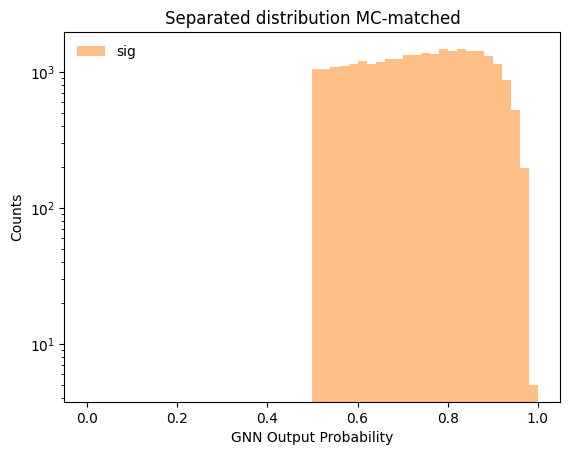

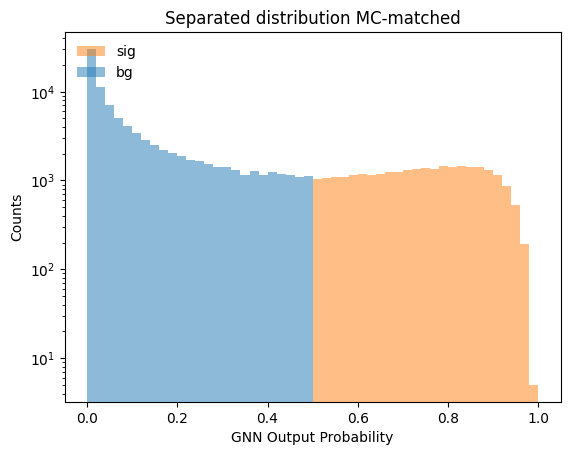

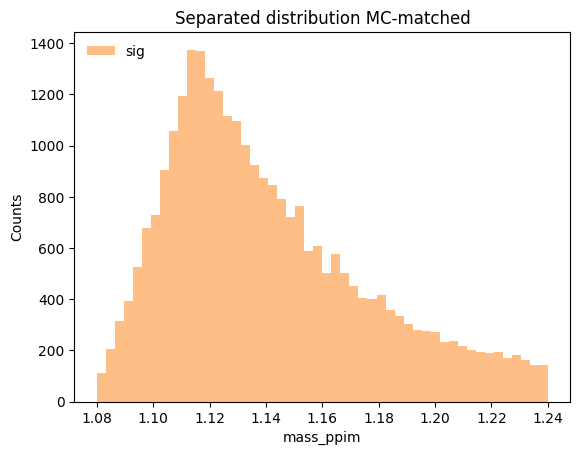

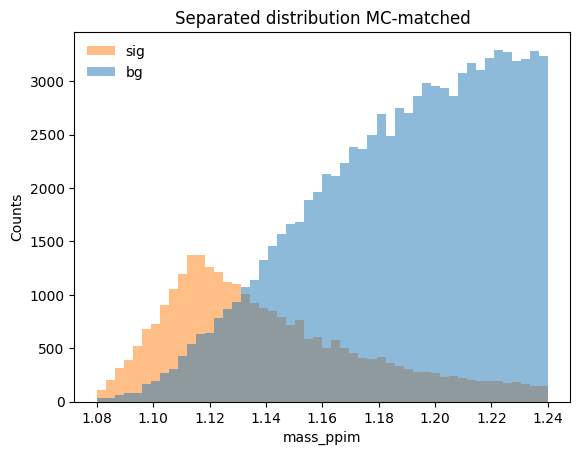

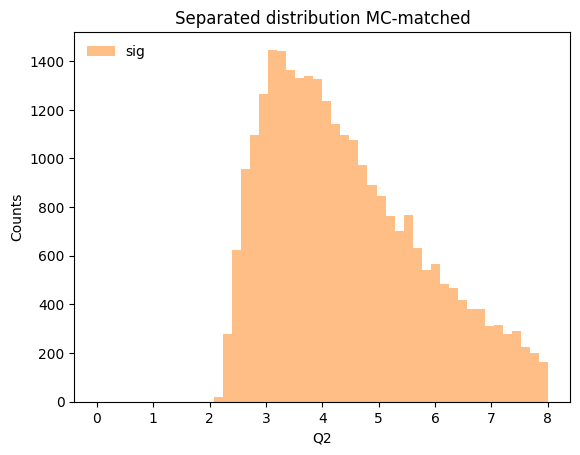

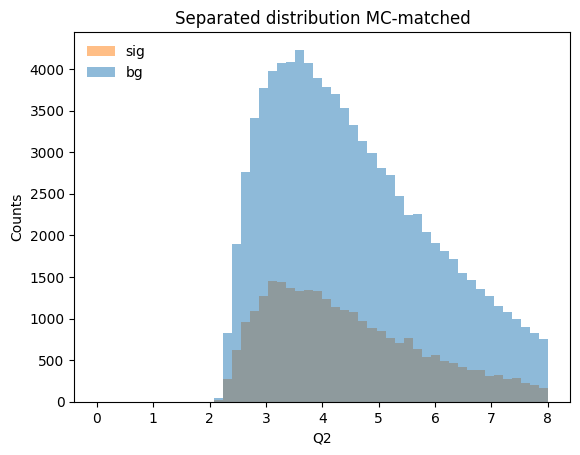

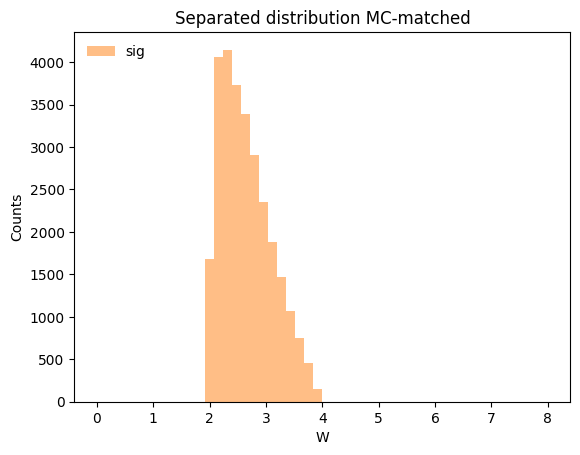

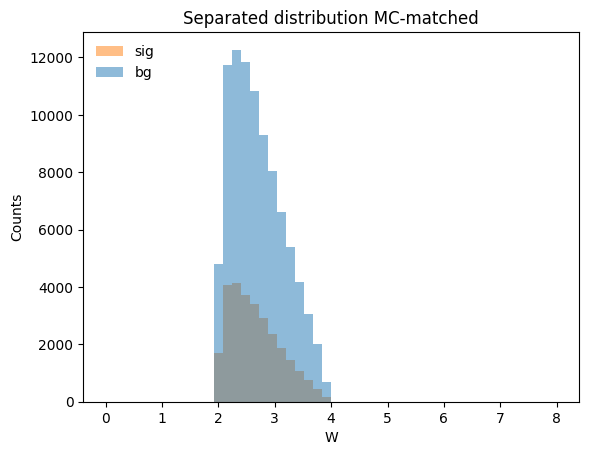

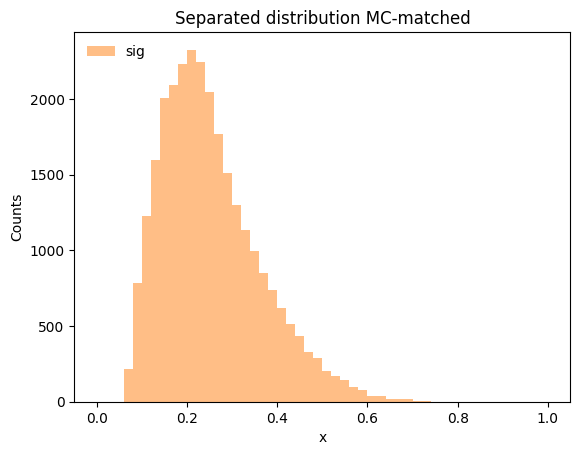

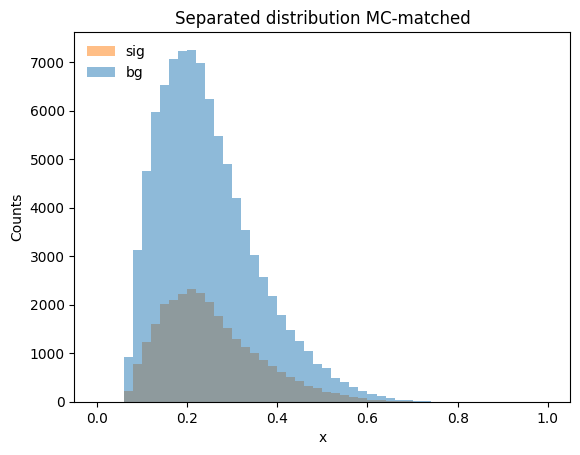

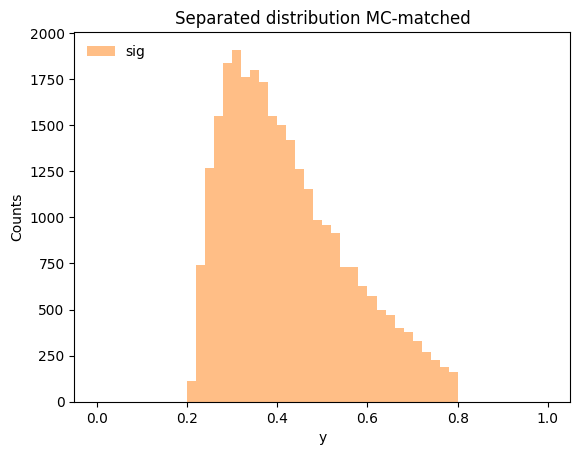

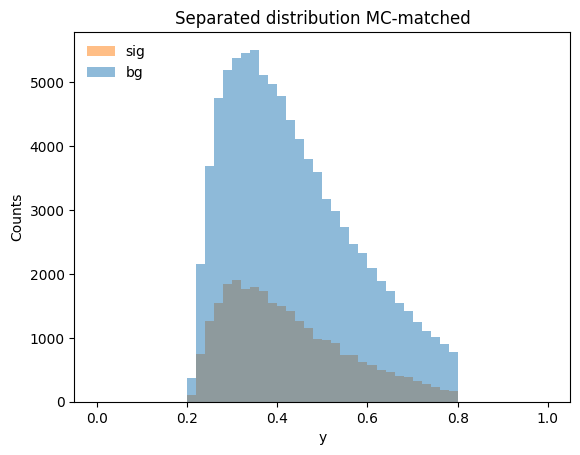

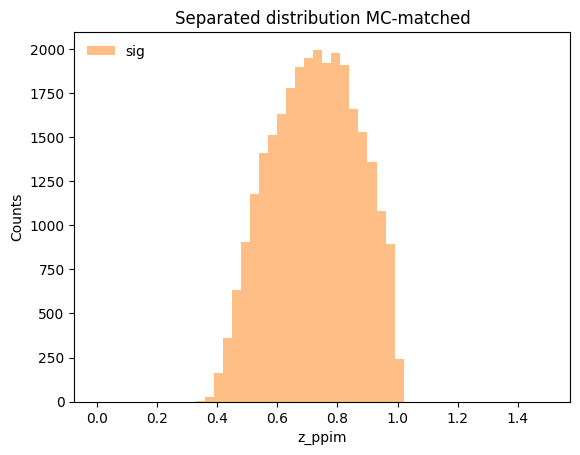

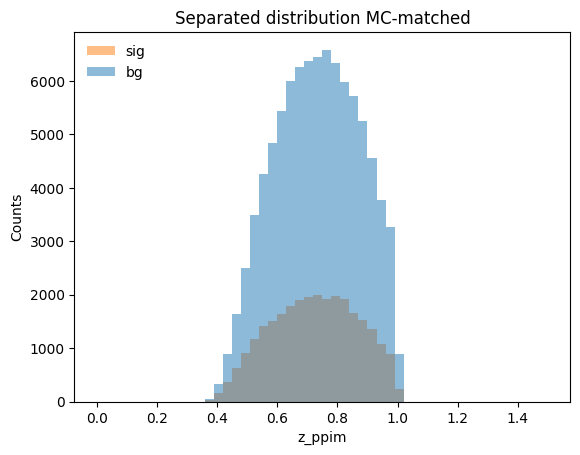

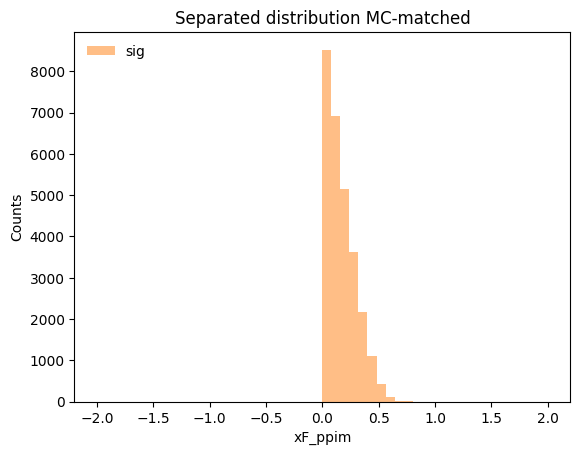

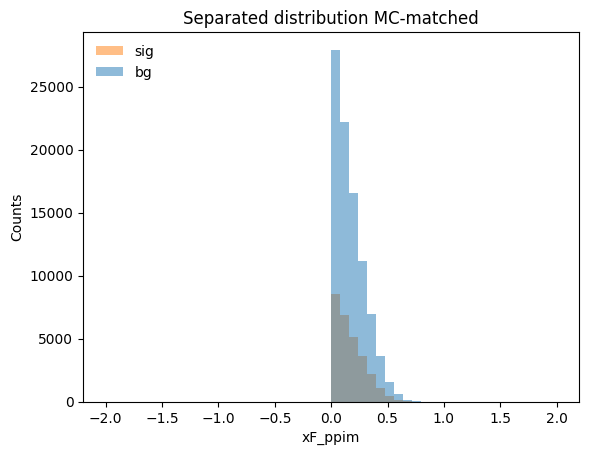

In [16]:
train_loss, outputs, decisions = data_test(data_test_loader)

# Get separated network output arrays
print("DEBUGGING: len(outputs)    = ",len(outputs))
print("DEBUGGING: outputs[0:10]   = ",outputs[0:10])
print("DEBUGGING: decisions[0:10] = ",decisions[0:10])
outputs   = np.array([el.tolist() for el in outputs])
decisions = np.array([el.item() for el in decisions])
print("DEBUGGING: AFTER CREATING np.arrays")
print("DEBUGGING: outputs[0:10]   = ",outputs[0:10])
print("DEBUGGING: decisions[0:10] = ",decisions[0:10])
print("DEBUGGING: type(outputs)       = ",type(outputs))
print("DEBUGGING: type(decisions)     = ",type(decisions))
print("DEBUGGING: np.shape(outputs)   = ",np.shape(outputs))
print("DEBUGGING: np.shape(decisions) = ",np.shape(decisions))
print("DEBUGGING: np.shape(decisions==1) = ",np.shape(decisions==1))
outputs_sig  = outputs[:,1][decisions==1]
outputs_bg   = outputs[:,1][decisions==0]

l_sig = []
l_bg = []
k_sig = []
k_bg = []
for i, data in enumerate(data_dataset):
    decision = decisions[i]
#     y = y_true[i]
    kin = data.kinematics.tolist()
#     if len(kin)!=13: raise TypeError
    if decision==1:
        l_sig.append(data)
        k_sig.append(kin[0])#NOTE: Should add matching indices specification to data objects...
    if decision==0:
        l_bg.append(data)
        k_bg.append(kin[0])
        
b_sig = torch_geometric.data.Batch().from_data_list(l_sig)
b_bg  = torch_geometric.data.Batch().from_data_list(l_bg)
print(b_sig.x.shape)
print(b_sig.y.shape)
print(b_bg.x.shape)
print(b_bg.y.shape)

import matplotlib.pyplot as plt

def plot_data_separated(array_sig,array_bg,title=None,xlabel='index',nbins=50,low=-1.1,high=1.1,logy=False):
    
    array_sig = array_sig.flatten()
    array_bg = array_bg.flatten()
    
    # Plot SIG ONLY distributions
    f = plt.figure()
    if title != None:
        plt.title(title)
    plt.title('Separated distribution MC-matched')
    plt.hist(array_sig, color='tab:orange', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='sig')
#     plt.hist(array_bg, color='tab:blue', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='bg')
    plt.legend(loc='upper left', frameon=False)
    plt.ylabel('Counts')
    plt.xlabel(xlabel)
    if logy: plt.yscale('log')
#     f.savefig(xlabel+'_data_separated_'+todays_date+'.pdf')

    # Plot SIG and BG distributions
    f = plt.figure()
    if title != None:
        plt.title(title)
    plt.title('Separated distribution MC-matched')
    plt.hist(array_sig, color='tab:orange', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='sig')
    plt.hist(array_bg, color='tab:blue', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='bg')
    plt.legend(loc='upper left', frameon=False)
    plt.ylabel('Counts')
    plt.xlabel(xlabel)
    if logy: plt.yscale('log')
#     f.savefig(xlabel+'_data_separated_'+todays_date+'.pdf')
    plt.show()
    
arr1 = b_sig.x
arr2 = b_bg.x
    
# # Plot data separated distributions
# plot_data_separated(arr1[:,0],arr2[:,0],xlabel="pT")
# plot_data_separated(arr1[:,1],arr2[:,1],xlabel="phi")
# plot_data_separated(arr1[:,2],arr2[:,2],xlabel="theta")
# plot_data_separated(arr1[:,3],arr2[:,3],xlabel="beta")
# plot_data_separated(arr1[:,4],arr2[:,4],xlabel="chi2")
# plot_data_separated(arr1[:,5],arr2[:,5],xlabel="pid")
# plot_data_separated(arr1[:,6],arr2[:,6],xlabel="status")

print(len(k_sig))
print(len(k_sig[1]))
arr1 = np.array(k_sig)
arr2 = np.array(k_bg)
print(type(arr1))
print(type(arr1[0]))
print(arr1.shape)
print(arr1[0].shape)
#mass_index, Q2_index, W_index, x_index, y_index, z_index, xF_index, mc_pid_pa_p_index, mc_pid_ppa_p_index, mc_idx_pa_p_index, mc_idx_ppa_p_index, mc_idx_pa_pim_index, mc_label_index
# Plot data separated distributions
plot_data_separated(outputs_sig,outputs_bg,xlabel="GNN Output Probability",low=0.0,high=1.0,logy=True)
plot_data_separated(arr1[:,10],arr2[:,10],xlabel="mass_ppim",low=1.08,high=1.24)
plot_data_separated(arr1[:,4],arr2[:,4],xlabel="Q2",low=0.0,high=8.0)
plot_data_separated(arr1[:,5],arr2[:,5],xlabel="W",low=0.0,high=8.0)
plot_data_separated(arr1[:,6],arr2[:,6],xlabel="x",low=0.0,high=1.0)
plot_data_separated(arr1[:,7],arr2[:,7],xlabel="y",low=0.0,high=1.0)
plot_data_separated(arr1[:,8],arr2[:,8],xlabel="z_ppim",low=0.0,high=1.5)
plot_data_separated(arr1[:,9],arr2[:,9],xlabel="xF_ppim",low=-2.0,high=2.0)




In [17]:
# # Train model batch size 32 lr 0.001
# nepochs = 5
# for epoch in range(nepochs):
#     print("BEFORE TRAIN()")
#     train()
#     print("BEFORE TEST(TRAIN_LOADER)")
#     train_acc, train_loss = test(train_loader)
#     print("BEFORE TEST(VAL_LOADER)")
#     val_acc, val_loss = test(val_loader)
#     print("Train acc: ",train_acc," loss: ",train_loss)
#     print("Val   acc: ",val_acc,  " loss: ",val_loss)

In [ ]:
# # Train model batch size 8 lr 0.01
# nepochs = 5
# for epoch in range(nepochs):
#     print("BEFORE TRAIN()")
#     train()
#     print("BEFORE TEST(TRAIN_LOADER)")
#     train_acc, train_loss = test(train_loader)
#     print("BEFORE TEST(VAL_LOADER)")
#     val_acc, val_loss = test(val_loader)
#     print("Train acc: ",train_acc," loss: ",train_loss)
#     print("Val   acc: ",val_acc,  " loss: ",val_loss)

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # ys = None
# # for data in train_loader:
# #     if ys is None: ys = data.y
# #     else: ys = torch.concatenate([ys,data.y])
# # counts = torch.unique(ys,return_counts=True)[1]
# # weights = counts / len(ys)
# # weights = np.power(weights,-1)
# # weight = torch.tensor([weights[idx] for idx in torch.squeeze(ys)]).to(device)
# # print("DEBUGGING: counts = ",torch.unique(ys,return_counts=True))
# # print("DEBUGGING: weight = ",weight)
# # criterion = torch.nn.BCELoss(weight=weight)

# def train(loader):
#     model.train()
#     loss_tot = 0.0
# #     print("DEBUGGING: beginning train(loader) len(loader) = ",len(loader))
#     for data in loader:  # Iterate in batches over the training dataset.
#         counts = torch.unique(data.y,return_counts=True)[1]
# #         print("DEBUGGING: torch.unique(data.y,return_counts=True) = ",torch.unique(data.y,return_counts=True))#DEBUGGING
#         weights = counts / len(data.y)
#         weights = np.power(weights,-1)
# #         print("DEBUGGING: data.y = ",data.y)
#         weight = torch.tensor([weights[idx] for idx in torch.squeeze(data.y)]).to(device)

#         optimizer.zero_grad()  # Clear gradients.
    
#         criterion = torch.nn.BCELoss(weight=weight)#weight=weight
# #         criterion = torch.nn.NLLLoss()
        
#         data = data.to(device)#NOTE: ADDED
# #         print("-> data.x.max() = ",data.x.max())
#         out = torch.squeeze(model(data.x, data.edge_index, data.batch)) #NOTE: REMOVED TORCH.SQUEEZE 2/28/23  # Perform a single forward pass.
# #         print("DEBUGGING: out = ",out)#DEBUGGING
# #         print("DEBUGGING: data.x = ",data.x)
# #         print("DEBUGGING: data.y.float() = ",data.y.float())#DEBUGGING
# #         print("DEBUGGING: out.shape = ",out.shape," data.y.float().shape = ",data.y.float().shape)#DEBUGGING
#         loss = criterion(out, data.y.float())  # Compute the loss.
# #         loss = criterion(out, data.y)  # Compute the loss.
# #         print("DEBUGGING: out = ",out)
# #         print("DEBUGGING: pred = ",out.round())
# #         print("DEBUGGING: data.y = ",data.y)
# #         print("DEBUGGING: loss.item() = ",loss.item())
# #         break
# #         pred = torch.round(out)
# #         correct = int((pred == data.y).sum())  # Check against ground-truth labels.
# #         print("DEBUGGING: correct = ",correct)
        
#         loss.backward()  # Derive gradients.
#         optimizer.step()  # Update parameters based on gradients.
# #         optimizer.zero_grad()  # Clear gradients. #NOTE: COMMENTED OUT BECAUSE PUT ABOVE FOR DEBUGGING
# #         break
#         loss_tot += loss.item()
#     return loss_tot / len(loader.dataset)


# def val(loader):
#     model.eval()

#     correct = 0
#     loss_tot = 0.0
#     with torch.no_grad():
#     #     print("DEBUGGING: beginning val(loader) len(loader) = ",len(loader))
#         for data in loader:  # Iterate in batches over the training/test dataset.
#             counts = torch.unique(data.y,return_counts=True)[1]
#             weights = counts / len(data.y)
#             weights = np.power(weights,-1)
#             weight = torch.tensor([weights[idx] for idx in torch.squeeze(data.y)]).to(device)
#             criterion = torch.nn.BCELoss(weight=weight)#weight=weight
# #             criterion = torch.nn.NLLLoss()

#             data = data.to(device)#NOTE: ADDED
#     #         print("DEBUGGING: data.batch = ",data.batch)
#             out = torch.squeeze(model(data.x, data.edge_index, data.batch)) #NOTE: REMOVED TORCH.SQUEEZE 2/28/23
#     #         print("-> data.x.max() = ",data.x)
#     #         print("DEBUGGING: out = ",out)
#     #         print("DEBUGGING: pred = ",torch.round(out))
#             loss = criterion(out, data.y.float())  # Compute the loss.
# #             loss = criterion(out, data.y)  # Compute the loss.
#     #         pred = out.argmax(dim=1)  # Use the class with highest probability.
#             pred = torch.round(out) #NOTE: JUST FOR USING BCELOSS -> ARGMAX COLLAPSES TO A ONE ELEMENT TENSOR
# #             print("-> data.x.max() = ",data.x.max())
# #             print("DEBUGGING: weights =")
# #             print("DEBUGGING: out = ",out)
# #             print("DEBUGGING: pred = ",pred)
# #             print("DEBUGGING: data.y = ",data.y)
# #             print("DEBUGGING: loss.item() = ",loss.item())

#             correct += int((pred == data.y).sum())  # Check against ground-truth labels.
# #             print("DEBUGGING: correct = ",correct)
#             loss_tot += loss.item()
#         return correct / len(loader.dataset), loss_tot / len(loader.dataset)  # Derive ratio of correct predictions.

# nepochs = 100
# for epoch in range(1, nepochs+1):
#     train_loss_tot = train(train_loader)
#     train_acc, train_loss = val(train_loader)
#     val_acc, val_loss = val(val_loader)
#     print("DEBUGGING: train_loss_tot = ",train_loss_tot)#DEBUGGING
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f} Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f} Loss: {val_loss:.4f}')
    
# test_acc, test_loss = val(test_loader)
# print(f'Test Acc: {train_acc:.4f} Loss: {train_loss:.4f}')

In [ ]:
#NOTE: COULD DEPLOY THIS ON IFARM...

#TODO:
# * ADD LEARNING RATE STEPPING INTO PL
# * CONVERT MODEL TO SEQUENTIAL SO YOU CAN SPECIFY NUMBER OF GRAPH AND LINEAR LAYERS AND POOLING TYPE
# * WRITE GIN/MLP MODELS
# * FIGURE OUT HOW TO INTEGRATE WITH HYPEROPTIMIZATION
# * FIGRE OUT HOW TO INTEGRATE WITH MLFLOW OR SOME OTHER TRACKING PACKAGE

In [11]:
# #TODO: IMPLEMENT WITH PYTORCH-LIGHTNING
# import torch
# from torchmetrics import Accuracy
# from torch.utils.data import random_split

# import pytorch_lightning as pl
# from pytorch_lightning import LightningModule, Trainer
# from pytorch_lightning.callbacks.progress import TQDMProgressBar
# from pytorch_lightning.loggers import CSVLogger

# class PLModel(pl.LightningModule):

#     def __init__(self,
#                  model_class = None,
#                  model_class_args = [],
#                  model_class_kwargs = {},
#                  criterion = None,
#                  optimizer = None,
#                  optimizer_kwargs = None,
#                  task = "binary",
#                  num_classes = 1,
#                  weight = True,
#                  dataset_class = None,
#                  ds_args = [],
#                  ds_kwargs = {},
#                  lengths = [1.0],
#                  dataloader_class = None,
#                  train_batch_size = 64,
#                  val_batch_size = 64,
#                  test_batch_size = 64,
#                  num_workers = 4
#                 ):
#         super(PLModel, self).__init__()
#         self.criterion = criterion if criterion is not None else F.binary_cross_entropy
#         self.optimizer = optimizer
#         self.optimizer_kwargs = optimizer_kwargs
#         self.task = task
#         if self.task!='binary': raise TypeError('PLModel: Only binary classification implemented so far')
#         self.num_classes = num_classes #NOTE: FOR BCELoss SHOULD HAVE NUM_CLASSES=1.
#         self.weight = weight #NOTE: Whether or not to use loss weighting on batch basis
#         self.dataset_class = dataset_class
#         self.ds_args = ds_args
#         self.ds_kwargs = ds_kwargs
#         self.lengths = lengths
#         self.dataloader_class = dataloader_class
#         self.train_batch_size = train_batch_size
#         self.val_batch_size = val_batch_size
#         self.test_batch_size = test_batch_size
#         self.num_workers = num_workers
        
#         # Init random class attributes
#         self.dataset = None
#         self.ds_train = None
#         self.ds_val = None
#         self.ds_test = None
        
#         self.train_accuracy = Accuracy(task=self.task, num_classes=self.num_classes)
#         self.val_accuracy = Accuracy(task=self.task, num_classes=self.num_classes)
#         self.test_accuracy = Accuracy(task=self.task, num_classes=self.num_classes)
        
#         self.model = model_class(*model_class_args,**model_class_kwargs)

#     def training_step(self, batch, batch_idx):
#         x = torch.squeeze(self.model(batch.x, batch.edge_index, batch.batch))
#         counts = torch.pow(torch.unique(batch.y,return_counts=True)[1] / len(batch.y), -1) if self.weight else None
#         weight = torch.tensor([counts[idx] for idx in torch.squeeze(batch.y)]).to(x.device) if self.weight else None #NOTE: THIS ONLY WORKS FOR BINARY CLASSIFICATION WITH BCELOSS
#         loss = self.criterion(x, batch.y.float(), weight=weight)
#         self.log('train_loss', loss, prog_bar=True)
#         self.log('train_acc', self.train_accuracy, prog_bar=True, batch_size=self.train_batch_size)
#         return loss
    
#     @torch.no_grad()
#     def validation_step(self, batch, batch_idx):
#         x = torch.squeeze(self.model(batch.x, batch.edge_index, batch.batch))
#         counts = torch.pow(torch.unique(batch.y,return_counts=True)[1] / len(batch.y), -1) if self.weight else None
#         weight = torch.tensor([counts[idx] for idx in torch.squeeze(batch.y)]).to(x.device) if self.weight else None #NOTE: THIS ONLY WORKS FOR BINARY CLASSIFICATION WITH BCELOSS
#         loss = self.criterion(x, batch.y.float(), weight=weight)
#         preds = x.round() #NOTE: ONLY USE FOR BINARY CLASSIFICATION
#         self.val_accuracy.update(preds, batch.y)

#         # Calling self.log will surface up scalars for you in TensorBoard
#         self.log('val_loss', loss, prog_bar=True, batch_size=self.val_batch_size)
#         self.log('val_acc', self.val_accuracy, prog_bar=True, batch_size=self.val_batch_size)
#         return loss
    
#     @torch.no_grad()
#     def test_step(self, batch, batch_nb):
#         x = torch.squeeze(self.model(batch.x, batch.edge_index, batch.batch))
#         counts = torch.pow(torch.unique(batch.y,return_counts=True)[1] / len(batch.y), -1) if self.weight else None
#         weight = torch.tensor([counts[idx] for idx in torch.squeeze(batch.y)]).to(x.device) if self.weight else None #NOTE: THIS ONLY WORKS FOR BINARY CLASSIFICATION WITH BCELOSS
#         loss = self.criterion(x, batch.y.float(), weight=weight)
#         preds = x.round() #NOTE: ONLY USE FOR BINARY CLASSIFICATION
#         self.val_accuracy.update(preds, batch.y)

#         # Calling self.log will surface up scalars for you in TensorBoard
#         self.log('test_loss', loss, prog_bar=True, batch_size=self.test_batch_size)
#         self.log('test_acc', self.test_accuracy, prog_bar=True, batch_size=self.test_batch_size)
#         return loss

#     def configure_optimizers(self):
#         if self.optimizer is not None and self.optimizer_kwargs is not None:
#             return self.optimizer(self.parameters(), **self.optimizer_kwargs)
#         else:
#             return torch.optim.Adam(self.parameters(), lr=0.01)
            
#     def prepare_data(self): #NOTE: DO NOT MAKE ANY STATE ASSIGNMENTS HERE, JUST DOWNLOAD THE DATA IF NEEDED
#         pass

#     def setup(self, stage=None): #NOTE: THIS RUNS ACROSS ALL GPUS
#         # Assign train/val/test datasets for use in dataloaders
#         if self.dataset is None:
#             self.dataset = self.dataset_class(*self.ds_args,**self.ds_kwargs) #NOTE: NEEDED KWARGS datasetclass ds_args, ds_kwargs, lengths
#         if len(self.lengths)==2 and self.ds_train is None and self.ds_val is None:
#             self.ds_train, self.ds_val = random_split(self.dataset, self.lengths)
#         elif len(self.lengths)==3 and self.ds_train is None and self.ds_val is None:
#             self.ds_train, self.ds_val, self.ds_test = random_split(self.dataset, self.lengths)

#     def train_dataloader(self):
#         return self.dataloader_class(self.ds_train, batch_size=self.train_batch_size, shuffle=True, num_workers=self.num_workers) #NOTE: NEEDED KWARGS dataloader_class train_batch_size val test...

#     def val_dataloader(self):
#         return self.dataloader_class(self.ds_val, batch_size=self.val_batch_size, shuffle=False, num_workers=self.num_workers)

#     def test_dataloader(self):
#         return self.dataloader_class(self.ds_test, batch_size=self.test_batch_size, shuffle=False, num_workers=self.num_workers)
            


In [13]:
# import torch
# from torch_geometric.loader import DataLoader
# import torch_geometric.transforms as T
# transform = T.Compose([T.ToUndirected(),T.NormalizeFeatures()]) #T.AddSelfLoops(),

# plmodel = PLModel(
#          model_class = GCN,
#          model_class_args = [],
#          model_class_kwargs = {'in_channels':dataset.num_node_features,'hidden_channels':64,'out_channels':1},
#          criterion = torch.nn.functional.binary_cross_entropy,
#          optimizer = torch.optim.Adam,
#          optimizer_kwargs = {'lr':0.01},
#          task = 'binary',
#          num_classes = 1,
#          weight = True,
#          dataset_class = MyOwnDataset,
#          ds_args = ['/work/clas12/users/mfmce/pyg_datasets/'],
#          ds_kwargs = {'transform':transform, 'pre_transform':None, 'pre_filter':None},
#          lengths = [0.8,0.1,0.1],
#          dataloader_class = DataLoader,
#          train_batch_size = 16,
#          val_batch_size = 16,
#          test_batch_size = 16,
#          num_workers = 4
#         )

# print(type(plmodel))
# print(type(plmodel.model))

<class '__main__.PLModel'>
<class '__main__.GCN'>


In [17]:
# trainer = Trainer(
#     default_root_dir="./", #NOTE: PL AUTOMATICALLY SAVES PL CHECKPOINT TO PWD UNLESS THIS OPTION IS DIFFERENT
#     accelerator="auto",
#     devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
#     max_epochs=3,
#     callbacks=[TQDMProgressBar(refresh_rate=20)],
#     logger=CSVLogger(save_dir="logs/"),
# #     deterministic=True
# )
# trainer.fit(plmodel)

# #NOTE: NEED TO FIGURE OUT HOW TO LOAD BEST MODEL
# script = plmodel.to_torchscript() #NOTE: extra method needed for pl

# # save for use in production environment
# torch.jit.save(script, "model.pt")

# #FOR INTEGRATING WITH MLFLOW
# # from pytorch_lightning.loggers import MLFlowLogger

# # mlf_logger = MLFlowLogger(experiment_name="lightning_logs", tracking_uri="file:./ml-runs")
# # trainer = Trainer(logger=mlf_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type           | Params
--------------------------------------------------
0 | train_accuracy | BinaryAccuracy | 0     
1 | val_accuracy   | BinaryAccuracy | 0     
2 | test_accuracy  | BinaryAccuracy | 0     
3 | model          | GCN            | 17.4 K
--------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.070     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


AttributeError: 'GCN' object has no attribute 'to_torchscript'

In [18]:
# trainer.test()

/w/hallb-scshelf2102/clas12/users/mfmce/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/lightning_logs/version_15/checkpoints/epoch=2-step=14073.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at logs/lightning_logs/version_15/checkpoints/epoch=2-step=14073.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss           1.3851436376571655
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/w/hallb-scshelf2102/clas12/users/mfmce/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric BinaryAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


[{'test_loss': 1.3851436376571655, 'test_acc': 0.0}]

In [14]:
# # Train model
# from pytorch_lightning.loggers import MLFlowLogger
# pl.seed_everything(72, workers=True)
# mlf_logger = MLFlowLogger(experiment_name="lightning_logs", tracking_uri="file:./ml-runs")
# trainer = Trainer(
#     default_root_dir="./", #NOTE: PL AUTOMATICALLY SAVES PL CHECKPOINT TO PWD UNLESS THIS OPTION IS DIFFERENT
#     accelerator="auto",
#     devices=1 if torch.cuda.is_available() else None,
#     max_epochs=3,
#     callbacks=[TQDMProgressBar(refresh_rate=20)],
# #     logger=CSVLogger(save_dir="logs/"),
#     deterministic=True, #NOTE: For reproducibility use pytorch_lightning.seed_everything and this
#     logger=mlf_logger
# )
# trainer.fit(plmodel)

# # Test model - pl automatically saves best and last checkpoints
# trainer.test(ckpt='best')

# # save for use in production environment
# script = plmodel.to_torchscript() #NOTE: Different method for pl
# torch.jit.save(script, "model.pt")

[rank: 0] Global seed set to 72
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Experiment with name lightning_logs not found. Creating it.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type           | Params
--------------------------------------------------
0 | train_accuracy | BinaryAccuracy | 0     
1 | val_accuracy   | BinaryAccuracy | 0     
2 | test_accuracy  | BinaryAccuracy | 0     
3 | model          | GCN            | 17.4 K
--------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.070     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


INFO: self.processed_paths =  ['/work/clas12/users/mfmce/pyg_datasets/processed/data.pt']


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


TypeError: test() got an unexpected keyword argument 'ckpt'

In [22]:
# !pip install -U 'mlflow>=1.0.0'

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 16.7 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 36.0 MB 138.2 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 75.2 MB/s  eta 0:00:01
     |████████████████████████████████| 79 kB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 100.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 129.2 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 44.8 MB/s  eta 0:00:01
     |████████████████████████████████| 101 kB 138.6 MB/s ta 0:00:01
     |████████████████████████████████| 42 kB 85.1 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 136.5 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 45.6 MB/s eta 0:00:01
     |████████████████████████████████| 151 kB 137.4 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 88.4 MB/s  eta 0:00:01
     |███████████████

In [29]:
# import os.path as osp

# import torch
# import torch.nn.functional as F

# import torch_geometric
# import torch_geometric.transforms as T
# from torch_geometric.datasets import TUDataset
# from torch_geometric.loader import DataLoader
# from torch_geometric.nn import MLP, GINConv, global_add_pool

# class GIN(torch.nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()

#         self.convs = torch.nn.ModuleList()
#         for _ in range(5):
#             mlp = MLP([in_channels, 32, 32])
#             self.convs.append(GINConv(mlp, train_eps=False))
#             in_channels = 32

#         self.mlp = MLP([32, 32, out_channels], norm=None, dropout=0.5)

#     def forward(self, x, edge_index, batch):
#         for conv in self.convs:
#             x = conv(x, edge_index).relu()
#         x = global_add_pool(x, batch)
#         return self.mlp(x)


# model = GIN(dataset.num_features, dataset.num_classes).to(device)

# # Compile the model into an optimized version:
# # Note that `compile(model, dynamic=True)` does not work yet in PyTorch 2.0, so
# # we use `transforms.Pad` and static compilation as a current workaround.
# # See: https://github.com/pytorch/pytorch/issues/94640
# # model = torch_geometric.compile(model)

# # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# # def train():
# #     model.train()

# #     total_loss = 0
# #     for data in train_loader:
# #         data = data.to(device)
# #         optimizer.zero_grad()
# #         out = model(data.x, data.edge_index, data.batch)
# #         loss = F.cross_entropy(out, data.y)
# #         loss.backward()
# #         optimizer.step()
# #         total_loss += float(loss) * data.num_graphs
# #     return total_loss / len(train_loader.dataset)


# # @torch.no_grad()
# # def test(loader):
# #     model.eval()

# #     total_correct = 0
# #     for data in loader:
# #         data = data.to(device)
# #         pred = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
# #         print(pred)
# #         total_correct += int((pred == data.y).sum())
# #     return total_correct / len(loader.dataset)


# # for epoch in range(1, 101):
# #     loss = train()
# #     train_acc = test(train_loader)
# #     test_acc = test(val_loader)
# #     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
# #           f'Test: {test_acc:.4f}')
# #     break